# Predictive Analytics: Prediksi Perilaku Pegawai
**Domain**: Ekonomi dan Bisnis

## Data Understanding

### Tentang Dataset

Dataset dalam penelitian ini diperoleh dari Kaggle dengan nama dataset 
[Hr Analytics Job Prediction](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction/data). Dataset ini berisi data pegawai yang bekerja di sebuah perusahaan, dengan 14999 baris data. Tujuan utama penelitian ini terhadap dataset ini adalah untuk membantu departemen HR dalam memprediksi perilaku karyawan, yaitu apakah pegawai resign atau tetap bekerja pada perusahaan tersebut.

Dataset ini tersedia dalam format CSV dan mencakup berbagai atribut yang relevan untuk analisis HR, antara lain:

- **satisfaction_level**: Tingkat kepuasan karyawan terhadap pegawaian mereka.
- **last_evaluation**: Skor evaluasi terakhir yang diterima oleh karyawan.
- **number_projects**: Jumlah proyek yang telah dikerjakan oleh karyawan.
- **average_montly_hours**: Rata-rata jam kerja bulanan karyawan.
- **time_spent_company**: Lama waktu (dalam tahun) karyawan bekerja di perusahaan.
- **Work_accident**: Apakah karyawan pernah mengalami kecelakaan kerja (0: tidak, 1: iya).
- **promotion_last_5years**: Apakah karyawan mendapatkan promosi dalam 5 tahun terakhir (0: tidak, 1: iya).
- **Department**: Departemen tempat karyawan bekerja (sales, technical, support, IT, RandD, product_mng, marketing, accounting, hr, management).
- **salary**: Tingkat gaji karyawan (low, medium, high).
- **left**: Fitur target dari dataset ini, sebagai indikator apakah karyawan telah meninggalkan perusahaan (0: tidak, 1: iya).

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import zscore
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV

### Load Dataset

In [2]:
# Load dataset
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Deskripsi Variabel

In [3]:
print("Total Baris dan Kolom:", df.shape)
print("Total Data:", df.size)

Total Baris dan Kolom: (14999, 10)
Total Data: 149990


In [4]:
#Cek tipe data dari setiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
#Cek rangkuman statistik untuk setiap fitur numerik 
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### 📌 **Insight dari Data Understanding**

Sebagian besar tipe data sudah benar. Saya akan mengonversi tipe data objek tertentu, seperti `salary` dan `Department` ke dalam format numerik, mungkin melalui encoding, untuk meningkatkan akurasi model. Untuk saat ini saya akan mengonversinya ke dalam tipe data kategorikal untuk EDA nanti. Saya juga akan memperbaiki typo pada penamaan kolom `average_montly_hours`. 

## Exploratory Data Analysis

### Exploratory Data Analysis - Data Cleaning

Dalam tahap ini, saya akan mengecek dan mengatasi data yang :
- Ubah nama kolom
- Missing values
- Duplikat
- Tipe data tidak tepat
- Outliers

#### Ubah Nama Kolom

In [6]:
# Ubah nama kolom menjadi huruf kecil, dan perbaiki typo pada nama kolom
df = df.rename(columns={'average_montly_hours': 'average_monthly_hours',
                        'Work_accident': 'work_accident',
                        'Department': 'department'})

# tampilkan nama kolom setelah diubah
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

#### Missing Values

In [7]:
# cek missing value
print("Missing Value:\n", df.isnull().sum())

Missing Value:
 satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64


#### Data Duplikat

In [8]:
# cek data duplikat
print("Data Duplikat:", df.duplicated().sum())

Data Duplikat: 3008


In [9]:
# Lihat data duplikat

duplicates = df[df.duplicated(keep=False)]
duplicates.head()

pd.concat([df, duplicates]).sort_values(by=df.columns.tolist())

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
...,...,...,...,...,...,...,...,...,...,...
4134,1.00,0.97,3,216,3,1,0,0,sales,low
7432,1.00,0.97,5,141,2,0,0,0,accounting,medium
5424,1.00,0.98,3,177,2,0,0,0,management,low
7612,1.00,0.99,4,184,4,0,0,0,support,low


In [10]:
#Cek persentase dan jumlah data duplikat
percentage_duplicates = (df.duplicated().sum() / len(df)) * 100
count_duplicates = df.duplicated().sum()
print(f"Persen baris duplikat: {percentage_duplicates:.2f}%")
print(f"Jumlah baris duplikat: {count_duplicates}")

Persen baris duplikat: 20.05%
Jumlah baris duplikat: 3008


Saya menemukan 3008 baris data yang terduplikasi yang merupakan 20,05% dari 14999 baris data. Nilai yang terduplikasi ini tidak menambah nilai atau informasi apa pun dan berpotensi menghambat proses visualisasi dan analisis data. Duplikasi tersebut juga dapat menyebabkan bias, tidak hanya dalam visualisasi, tetapi juga pada model.

In [11]:
#copy data df ke df_cleaned_duplicates
df_cleaned_duplicates = df.copy()

#Hapus data yang duplikat
df_cleaned_duplicates.drop_duplicates(inplace=True)
# data sebelum dihapus duplikat
print("Data sebelum dihapus duplikat:", df.shape[0])
# data setelah dihapus duplikat
print("Data setelah dihapus duplikat:", df_cleaned_duplicates.shape[0])
#cek apakah ada data duplikat setelah dihapus
print("Apakah masih ada data duplikat setelah dihapus?", df_cleaned_duplicates.duplicated().any())

Data sebelum dihapus duplikat: 14999
Data setelah dihapus duplikat: 11991
Apakah masih ada data duplikat setelah dihapus? False


#### Ubah Tipe Data

In [12]:
df_cleaned_duplicates['work_accident'] = df_cleaned_duplicates['work_accident'].astype('category')
df_cleaned_duplicates['promotion_last_5years'] = df_cleaned_duplicates['promotion_last_5years'].astype('category')
df_cleaned_duplicates['left'] = df_cleaned_duplicates['left'].astype('category')

In [13]:
for col in df_cleaned_duplicates.select_dtypes(include='object').columns:
    df_cleaned_duplicates[col] = df[col].astype('category')

In [14]:
# Cek tipe data setelah diubah
df_cleaned_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   time_spend_company     11991 non-null  int64   
 5   work_accident          11991 non-null  category
 6   left                   11991 non-null  category
 7   promotion_last_5years  11991 non-null  category
 8   department             11991 non-null  category
 9   salary                 11991 non-null  category
dtypes: category(5), float64(2), int64(3)
memory usage: 621.5 KB


#### Outliers

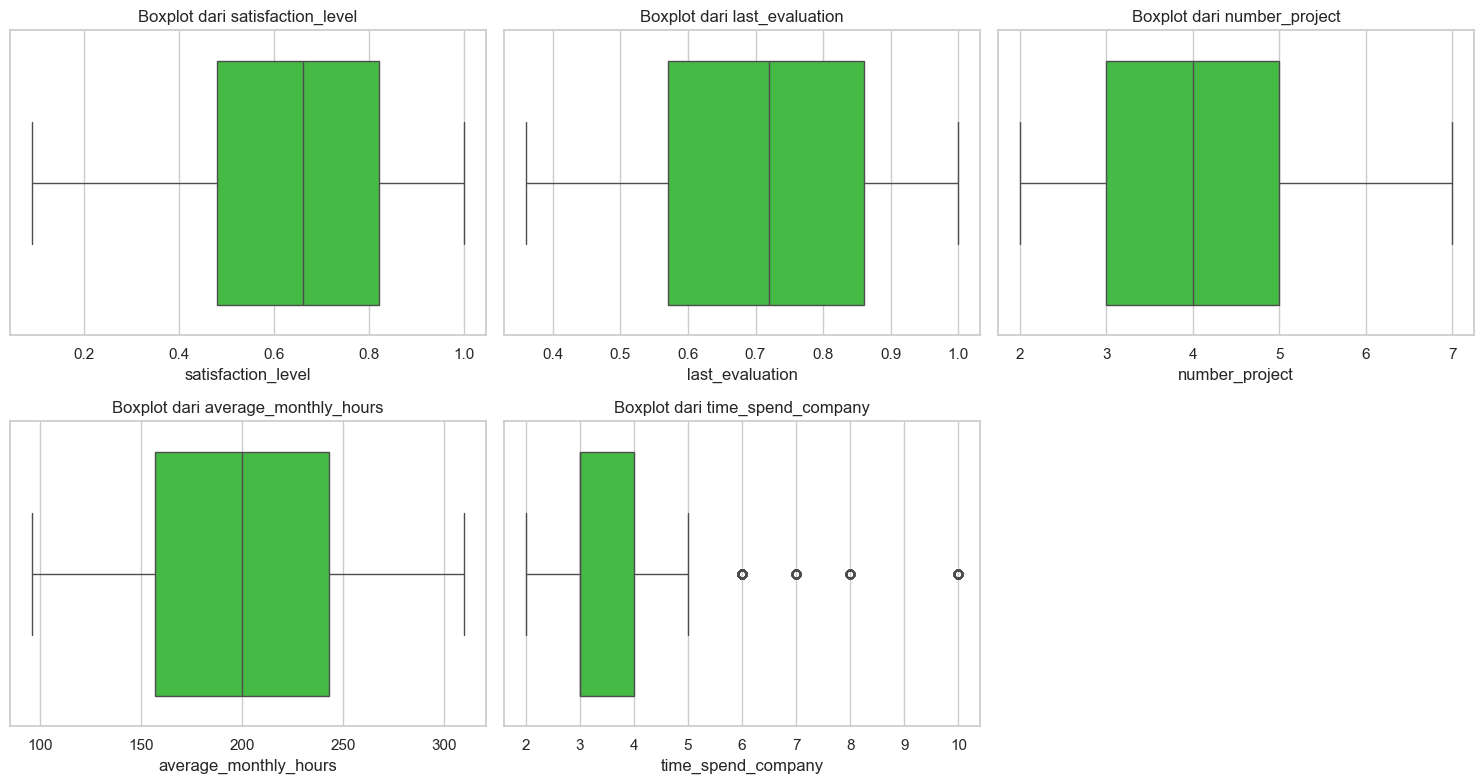

In [15]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Ambil kolom numerik, kecualikan kolom tertentu
numeric_cols = df_cleaned_duplicates.select_dtypes(include=['float64', 'int64']).columns
excluded_cols = ['work_accident', 'left', 'promotion_last_5years']
numeric_cols_filtered = [col for col in numeric_cols if col not in excluded_cols]

# Hitung baris dan kolom untuk subplot
n_cols = 3
n_rows = math.ceil(len(numeric_cols_filtered) / n_cols)

# Buat figure
plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numeric_cols_filtered):
    if i < n_rows * n_cols:  # Ensure the subplot index is within bounds
        plt.subplot(n_rows, n_cols, i + 1)
        sns.boxplot(data=df_cleaned_duplicates, x=col, color='limegreen')
        plt.title(f'Boxplot dari {col}')
plt.tight_layout()
plt.show()

In [16]:
# Hitung IQR untuk kolom 'time_spend_company'
Q1 = df_cleaned_duplicates['time_spend_company'].quantile(0.25)
Q3 = df_cleaned_duplicates['time_spend_company'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hitung jumlah outliers
outliers = df_cleaned_duplicates[(df_cleaned_duplicates['time_spend_company'] < lower_bound) | 
                                  (df_cleaned_duplicates['time_spend_company'] > upper_bound)]
jumlah_outliers = outliers.shape[0]
print(f"Jumlah outliers pada fitur 'time_spend_company': {jumlah_outliers}")

Jumlah outliers pada fitur 'time_spend_company': 824


Dari visual di atas, terdapat outliers pada kolom `time_spend_company`. Namun outlier nya tidaklah extreme. Jadi menurut saya tidak perlu menangani outlier tersebut. Mari kita lihat nanti performa model yang akan kita latih dengan dataset ini.

📌 **Insight dari Data Cleaning**

1. **Standardisasi Nama Kolom:**
   - Nama kolom diubah menjadi huruf kecil seluruhnya.
   - Typo diperbaiki, contohnya:
     - `average_montly_hours` → `average_monthly_hours`
     - `Work_accident` → `work_accident`
     - `Department` → `department`
   - Ini penting agar analisis berikutnya lebih konsisten, mencegah error karena typo atau perbedaan huruf kapital.

2. **Pengecekan dan Penanganan Missing Value:**
   - Dicek jumlah data kosong di semua kolom.
   - Dari hasilnya, **tidak ada missing value** di dataset ini, sehingga tidak perlu dilakukan imputasi atau pembuangan data.

3. **Cek dan Tangani Data Duplikat:**
   - Data diperiksa apakah ada yang duplikat.
   - Ditemukan beberapa data duplikat, lalu **duplikat dihapus**.
   - Setelah data duplikat dihapus, jumlah baris pada data adalah 11991.
   - Ini penting agar analisis tidak bias karena contoh data yang berulang.


4. **Ubah Tipe Data untuk Konsistensi:**
   - Ada pengubahan tipe data untuk kolom bertipe kategorikal agar konsisten formatnya (misal, merapikan kategori di kolom `department` dan `salary`).
   - Hal ini penting untuk memudahkan proses encoding nantinya.

5. **Deteksi Data Outlier:**
   - Dilakukan pengecekan distribusi untuk beberapa kolom numerik menggunakan boxplot. Terdapat outlier pada fitur `time_spend_company`
   - Kemudian outlier dideteksi dengan metode IQR. Jumlah data outlier pada fitur `time_spend_company`adalah sebanyak 824 baris
   - Namun, karena data outlier masih tergolong tidak extreme, maka data outlier dibiarkan saja. Ini juga berguna agar tidak ada pola yang hilang



### Exploratory Data Analysis - Univariate Analysis

In [17]:
df_cleaned = df_cleaned_duplicates.copy()

In [18]:
# Masukkan data numerik dan data kategorikal ke dalam list variabel
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_cols = df_cleaned.select_dtypes(include=['category']).columns.tolist()

In [19]:
num_cols

['satisfaction_level',
 'last_evaluation',
 'number_project',
 'average_monthly_hours',
 'time_spend_company']

In [20]:
cat_cols

['work_accident', 'left', 'promotion_last_5years', 'department', 'salary']

#### Categorical Features

##### Fitur left

       jumlah sampel  persentase
left                            
tidak          10000        83.4
iya             1991        16.6


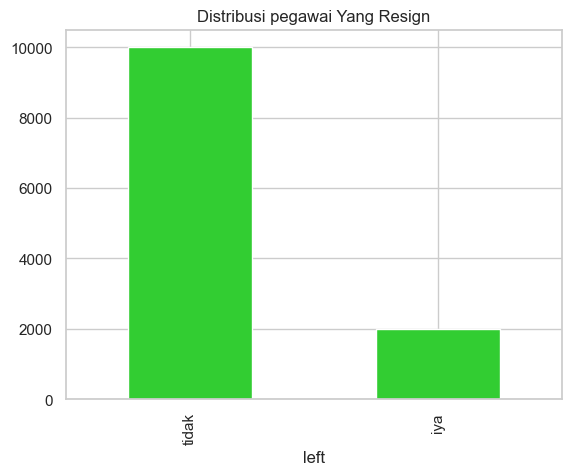

In [21]:
# Buat label sementara untuk plotting
temp_labels = df_cleaned['left'].map({0: 'tidak', 1: 'iya'})

feature = cat_cols[1]
count = temp_labels.value_counts()
percent = 100 * temp_labels.value_counts(normalize=True)
df_temp = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(df_temp)
count.plot(kind='bar', title="Distribusi pegawai Yang Resign", color='limegreen');

Dari grafik Distribusi pegawai Yang Resign dapat disimpulkan beberapa hal:
- Jumlah pegawai yang **tidak resign** jauh lebih banyak dibandingkan dengan yang **resign**.
- Jumlah pegawai yang **tidak resign** adalah **10000** dengan persentase **83.4**, sedangkan yang **resign** sekitar **1991** dengan persentase **16.6**.

##### Fitur work_accident

               jumlah sampel  persentase
work_accident                           
tidak                  10141        84.6
iya                     1850        15.4


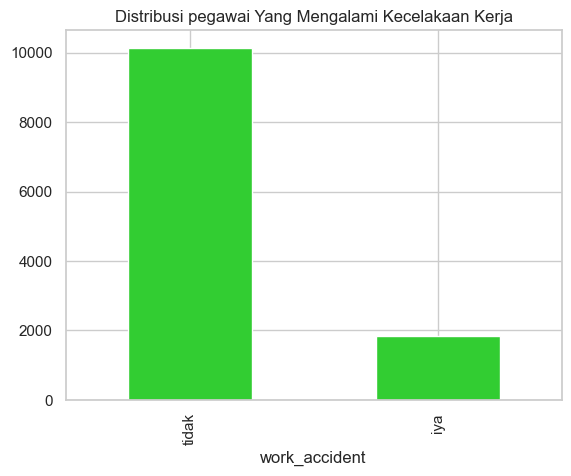

In [22]:
# Buat label sementara untuk plotting
temp_labels = df_cleaned['work_accident'].map({0: 'tidak', 1: 'iya'})

# Hitung jumlah dan persentase
count = temp_labels.value_counts()
percent = 100 * temp_labels.value_counts(normalize=True)
df_temp = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})

# Tampilkan dataframe
print(df_temp)

# Plot data
count.plot(kind='bar', title="Distribusi pegawai Yang Mengalami Kecelakaan Kerja", color='limegreen');

In [23]:
# Crosstab jumlah
work_accident_left_ct = pd.crosstab(df_cleaned['work_accident'].map({0: 'tidak pernah', 1: 'pernah'}), df_cleaned['left'].map({0: 'tidak', 1: 'iya'}), margins=True)

print(work_accident_left_ct)


left           tidak   iya    All
work_accident                    
tidak pernah    8255  1886  10141
pernah          1745   105   1850
All            10000  1991  11991


In [24]:
# Tambahkan kolom persentase yang resign dari total per kategori salary
work_accident_left_ct = pd.crosstab(df_cleaned['work_accident'].map({0: 'tidak pernah', 1: 'pernah'}), df_cleaned['left'], normalize='index') * 100
work_accident_left_ct.columns = ['Tidak Resign (%)', 'Resign (%)']
print(work_accident_left_ct)


               Tidak Resign (%)  Resign (%)
work_accident                              
tidak pernah          81.402229   18.597771
pernah                94.324324    5.675676


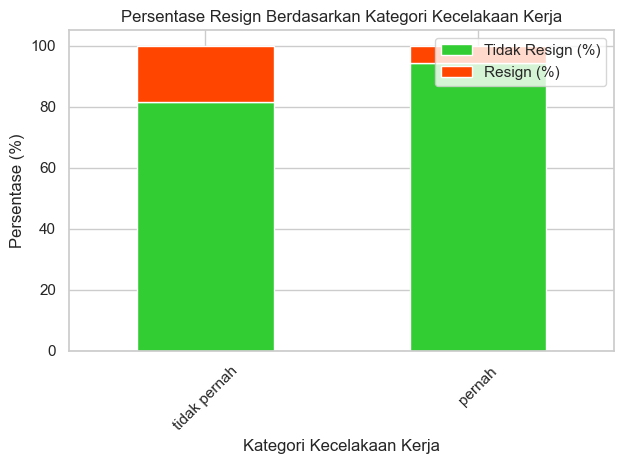

In [25]:
# Plot visualisasi persentase
work_accident_left_ct.plot(kind='bar', stacked=True, color=['limegreen', 'orangered'])
plt.title('Persentase Resign Berdasarkan Kategori Kecelakaan Kerja')
plt.ylabel('Persentase (%)')
plt.xlabel('Kategori Kecelakaan Kerja')
plt.xticks(ticks=[0, 1], labels=['tidak pernah', 'pernah'], rotation=45)  # Rotasi label x sebesar 45 derajat
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Dari analisa fitur work_accident:
- Jumlah pegawai yang **tidak pernah mengalami kecelakaan** jauh lebih banyak dibandingkan dengan yang **pernah mengalami kecelakaan**.
- Jumlah pegawai yang **tidak pernah mengalami kecelakaan** adalah **10141** dengan persentase **84.6**, sedangkan yang **pernah mengalami kecelakaan** sekitar **1850** dengan persentase **15.4**.
- Persentase pegawai yang resign dengan tidak pernah mengalami kecelakaan kerja lebih banyak dibandingkan yang pernah mengalami kecelakaan kerja. Ini berarti pernah atau tidaknya mengalami kecelakaan kerja bukan faktor yang mempengaruhi pegawai akan resign atau tidak di perusahaan tersebut.

##### Fitur promotion_last_5years

                       jumlah sampel  persentase
promotion_last_5years                           
tidak                          11788        98.3
iya                              203         1.7


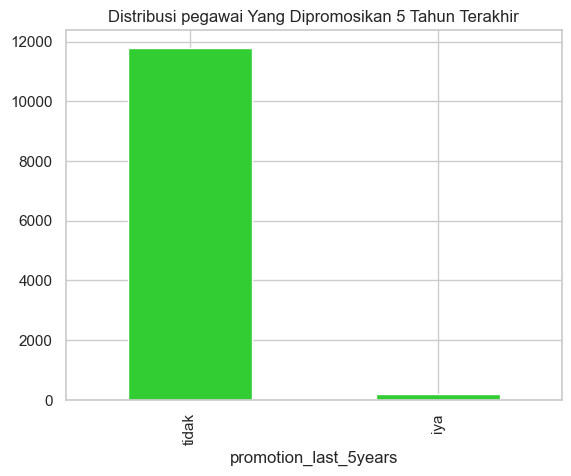

In [26]:
# Buat label sementara untuk plotting
temp_labels = df_cleaned['promotion_last_5years'].map({0: 'tidak', 1: 'iya'})

# Hitung jumlah dan persentase
count = temp_labels.value_counts()
percent = 100 * temp_labels.value_counts(normalize=True)
df_temp = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})

# Tampilkan dataframe
print(df_temp)

# Plot data
count.plot(kind='bar', title="Distribusi pegawai Yang Dipromosikan 5 Tahun Terakhir", color='limegreen');

In [27]:
# Crosstab jumlah
promotion_left_ct = pd.crosstab(df_cleaned['promotion_last_5years'].map({0: 'tidak pernah', 1: 'pernah'}), df_cleaned['left'].map({0: 'tidak', 1: 'iya'}), margins=True)
print(promotion_left_ct)


left                   tidak   iya    All
promotion_last_5years                    
tidak pernah            9805  1983  11788
pernah                   195     8    203
All                    10000  1991  11991


In [28]:
# Tambahkan kolom persentase yang resign dari total per kategori salary
promotion_left_ct = pd.crosstab(df_cleaned['promotion_last_5years'].map({0: 'tidak pernah', 1: 'pernah'}), df_cleaned['left'], normalize='index') * 100
promotion_left_ct.columns = ['Tidak Resign (%)', 'Resign (%)']
print(promotion_left_ct)


                       Tidak Resign (%)  Resign (%)
promotion_last_5years                              
tidak pernah                  83.177808   16.822192
pernah                        96.059113    3.940887


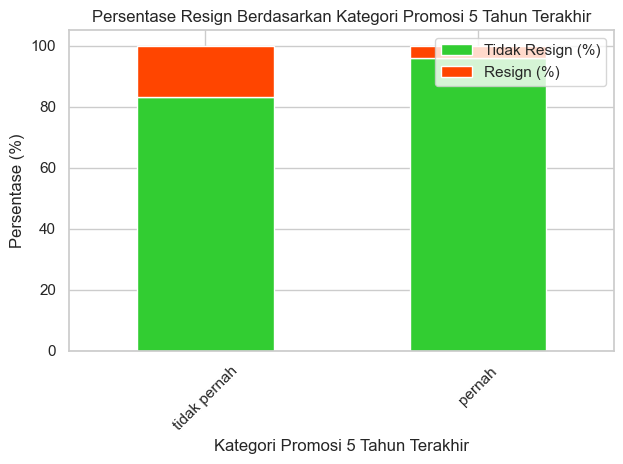

In [29]:
# Plot visualisasi persentase
promotion_left_ct.plot(kind='bar', stacked=True, color=['limegreen', 'orangered'])
plt.title('Persentase Resign Berdasarkan Kategori Promosi 5 Tahun Terakhir')
plt.ylabel('Persentase (%)')
plt.xlabel('Kategori Promosi 5 Tahun Terakhir')
plt.xticks(ticks=[0, 1], labels=['tidak pernah', 'pernah'], rotation=45)  # Rotasi label x sebesar 45 derajat
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Dari analisa fitur promotion_last_5years dapat disimpulkan beberapa hal:
- Jumlah pegawai yang **tidak pernah dipromosikan 5 tahun terakhir** jauh lebih banyak dibandingkan dengan yang **pernah dipromosikan 5 tahun terakhir**.
- Jumlah pegawai yang **tidak pernah dipromosikan 5 tahun terakhir** adalah **11788** dengan persentase **98.3**, sedangkan yang **pernah dipromosikan 5 tahun terakhir** sekitar **203** dengan persentase **1.7**.
- Persentase pegawai yang resign dengan tidak pernah mendapatkan promosi 5 tahun terakhir lebih banyak dibandingkan dengan pegawai yang pernah mendapatkan promosi 5 tahun terakhir. Ini berarti pegawai resign karena merasa kecewa akibat tidak pernah mendapatkan promosi 5 tahun terakhir selama bekerja di perusahaan tersebut. 

##### Fitur department

             jumlah sampel  persentase
department                            
sales                 3239        27.0
technical             2244        18.7
support               1821        15.2
IT                     976         8.1
RandD                  694         5.8
product_mng            686         5.7
marketing              673         5.6
accounting             621         5.2
hr                     601         5.0
management             436         3.6


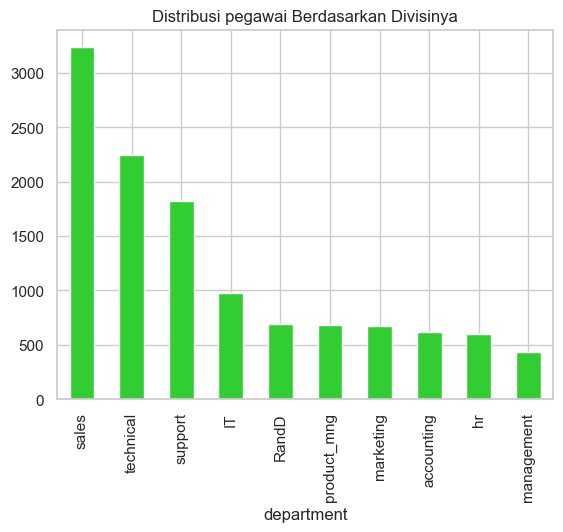

In [30]:
feature = cat_cols[3]
count = df_cleaned[feature].value_counts()
percent = 100*df_cleaned[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
print(df)
count.plot(kind='bar', title="Distribusi pegawai Berdasarkan Divisinya", color='limegreen');

In [31]:
# Crosstab jumlah
department_left_ct = pd.crosstab(df_cleaned['department'], df_cleaned['left'].map({0: 'tidak', 1: 'iya'}), margins=True)
print(department_left_ct)


left         tidak   iya    All
department                     
IT             818   158    976
RandD          609    85    694
accounting     512   109    621
hr             488   113    601
management     384    52    436
marketing      561   112    673
product_mng    576   110    686
sales         2689   550   3239
support       1509   312   1821
technical     1854   390   2244
All          10000  1991  11991


In [32]:
# Tambahkan kolom persentase yang resign dari total per kategori salary
department_left_ct = pd.crosstab(df_cleaned['department'], df_cleaned['left'], normalize='index') * 100
department_left_ct.columns = ['Tidak Resign (%)', 'Resign (%)']
print(department_left_ct)


             Tidak Resign (%)  Resign (%)
department                               
IT                  83.811475   16.188525
RandD               87.752161   12.247839
accounting          82.447665   17.552335
hr                  81.198003   18.801997
management          88.073394   11.926606
marketing           83.358098   16.641902
product_mng         83.965015   16.034985
sales               83.019450   16.980550
support             82.866557   17.133443
technical           82.620321   17.379679


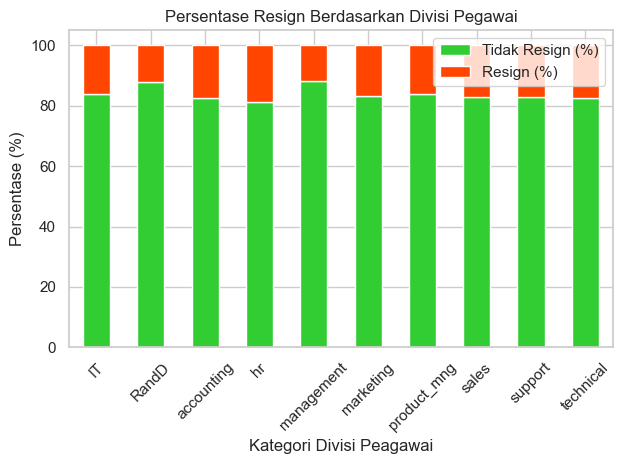

In [33]:
# Plot visualisasi persentase
department_left_ct = department_left_ct
department_left_ct.plot(kind='bar', stacked=True, color=['limegreen', 'orangered'])
plt.title('Persentase Resign Berdasarkan Divisi Pegawai')
plt.ylabel('Persentase (%)')
plt.xlabel('Kategori Divisi Peagawai')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Dari analisa fitur Department, dapat disimpulkan beberapa hal, yaitu:
- Divisi dengan jumlah pekerja **terbanyak** adalah **sales** (lebih dari 3000 karyawan).
- Disusul oleh **technical** dan **support**, keduanya juga memiliki proporsi yang signifikan.
- Divisi dengan jumlah karyawan **paling sedikit** adalah **management**, hanya sekitar **3.6%**, yang bisa dimaklumi karena biasanya posisi manajerial memang lebih sedikit.
- Tiga divisi teratas (**Sales, Technical, Support**) menyumbang lebih dari **60%** dari total tenaga kerja. Hal ini bisa menunjukkan bahwa perusahaan memiliki fokus besar pada **penjualan**, **dukungan teknis**, dan **layanan pelanggan**.
- **Divisi IT, R&D, dan Product Management** tergolong menengah, dan ini bisa menunjukkan perusahaan juga cukup memperhatikan sisi pengembangan teknologi dan produk — meski tidak sebesar tenaga sales dan support.
- Dapat dilihat persentase pegawai yang resign dari setiap divisi hampir sama semua. Jadi dapat disimpulkan bahwa pegawai tidak memiliki masalah terhadap divisi kerjanya di perusahaan tersebut.

##### Fitur salary

        jumlah sampel  persentase
salary                           
low              5740        47.9
medium           5261        43.9
high              990         8.3


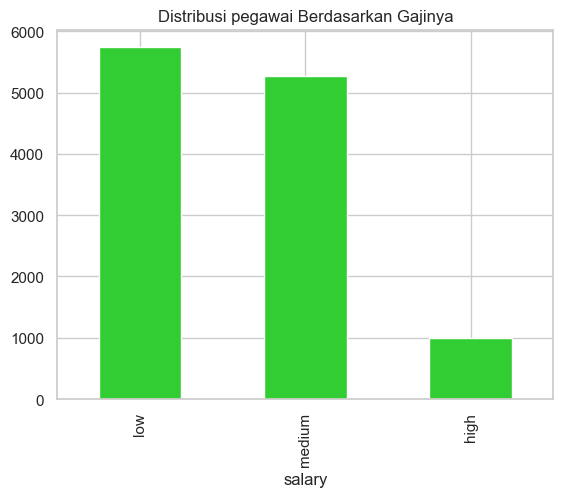

In [34]:
feature = cat_cols[4]
count = df_cleaned[feature].value_counts()
percent = 100 * df_cleaned[feature].value_counts(normalize=True)
df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(df)
count.plot(kind='bar', title="Distribusi pegawai Berdasarkan Gajinya", color='limegreen');

In [35]:
# Crosstab jumlah
salary_left_ct = pd.crosstab(df_cleaned['salary'], df_cleaned['left'].map({0: 'tidak', 1: 'iya'}), margins=True)
print(salary_left_ct)


left    tidak   iya    All
salary                    
high      942    48    990
low      4566  1174   5740
medium   4492   769   5261
All     10000  1991  11991


In [36]:
# Tambahkan kolom persentase yang resign dari total per kategori salary
salary_left_pct = pd.crosstab(df_cleaned['salary'], df_cleaned['left'], normalize='index') * 100
salary_left_pct.columns = ['Tidak Resign (%)', 'Resign (%)']
print(salary_left_pct)


        Tidak Resign (%)  Resign (%)
salary                              
high           95.151515    4.848485
low            79.547038   20.452962
medium         85.383007   14.616993


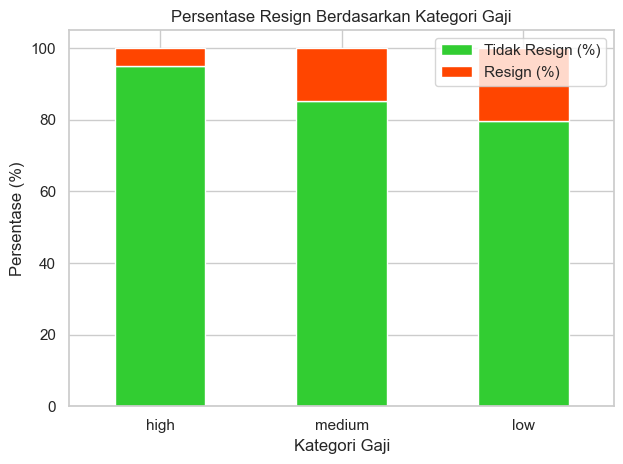

In [37]:
# Plot visualisasi persentase
salary_left_pct = salary_left_pct.reindex(['high', 'medium', 'low'])  # Urutkan indeks
salary_left_pct.plot(kind='bar', stacked=True, color=['limegreen', 'orangered'])
plt.title('Persentase Resign Berdasarkan Kategori Gaji')
plt.ylabel('Persentase (%)')
plt.xlabel('Kategori Gaji')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Berikut ini beberapa kesimpulan berdasarkan analisa fitur salary:
- Mayoritas karyawan berada di kategori gaji **rendah** (`low`), yaitu **5.740 orang** atau **47.9%** dari total populasi.
- Disusul oleh kategori **gaji menengah** (`medium`) sebanyak **5.261 orang** (**43.9%**).
- Sedangkan karyawan dengan **gaji tinggi** (`high`) hanya sekitar **990 orang** atau **8.3%**.
- Hampir 92% dari total karyawan memiliki gaji di level `low` dan `medium`, sedangkan hanya 8% yang menikmati gaji tinggi. Ini menunjukkan adanya kesenjangan distribusi kompensasi dalam perusahaan.
- Karena kelompok `low salary` memiliki proporsi terbesar, kelompok ini kemungkinan besar juga menyumbang sebagian besar kasus **resign** (yang perlu dikonfirmasi melalui analisis lebih lanjut). Gaji rendah umumnya dikaitkan dengan kepuasan kerja rendah dan kemungkinan lebih besar untuk mencari peluang kerja di tempat lain.
- Jika ternyata banyak pekerja dari kelompok gaji rendah yang resign, maka strategi peningkatan kesejahteraan, pelatihan, atau insentif bisa difokuskan ke kelompok ini untuk menurunkan angka turnover.
- Persentase pegawai yang resign semakin tinggi apabila gaji yang diberikan kepada pegawai semakin rendah.

#### Numerical Features

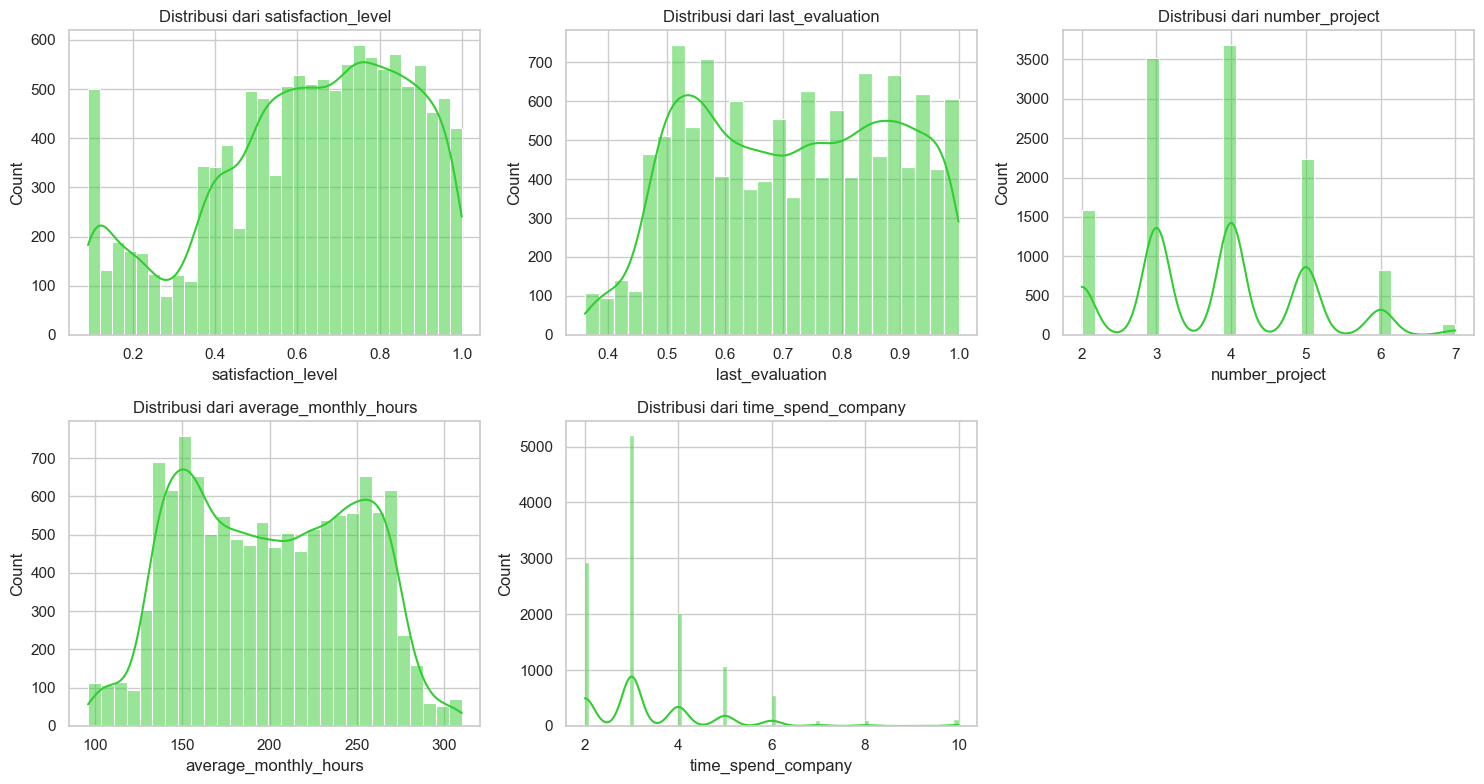

In [38]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Hitung baris dan kolom untuk subplot
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

# Buat figure
plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(num_cols):
    if i < n_rows * n_cols:  # Ensure the subplot index is within bounds
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(data=df_cleaned_duplicates, x=col, kde=True, color='limegreen')
        plt.title(f'Distribusi dari {col}')
plt.tight_layout()
plt.show()

Berdasarkan visualisasi grafik distribusi data numerik di atas, dapat disimpulkan beberapa hal.
1. **Satisfaction Level**
- **Distribusi** agak bimodal dan sedikit condong ke kanan.
- Ada dua puncak besar:
  - Sekitar **0.4–0.5** (rendah)
  - Sekitar **0.7–0.8** (tinggi)
- **Insight**:
  - Ada kelompok karyawan yang sangat puas dan cukup banyak yang kurang puas.
  - Karyawan dengan tingkat kepuasan rendah ini patut diawasi karena mereka berpotensi lebih besar untuk resign.

---

2. **Last Evaluation**
- Distribusi relatif **merata** dari 0.5 sampai 1, dengan sedikit puncak di area **0.55–0.6**.
- **Insight**:
  - Evaluasi kerja karyawan cenderung tersebar merata, artinya sistem penilaian cukup bervariasi.
  - Tidak ada indikasi bahwa karyawan yang performanya sangat rendah mendominasi.

---

3. **Number of Projects**
- Ada puncak jelas pada angka:
  - **3 proyek** (terbanyak)
  - **4 proyek** dan **5 proyek** menyusul
- Hanya sedikit karyawan yang menangani **lebih dari 5 proyek**.
- **Insight**:
  - Kebanyakan karyawan menangani 3–5 proyek.
  - Jumlah proyek ekstrem (sedikit atau banyak) sangat jarang dan bisa menjadi faktor stres/resign yang perlu dianalisis lebih lanjut.

---

4. **Average Monthly Hours**
- Distribusi **bimodal**:
  - Puncak di sekitar **150 jam** dan **250 jam** per bulan.
- Ada juga karyawan yang bekerja di atas **300 jam** per bulan, meskipun jumlahnya sedikit.
- **Insight**:
  - Ada dua pola kerja: yang cenderung normal dan yang bekerja sangat intens.
  - Karyawan yang bekerja lebih dari 250 jam kemungkinan mengalami **overwork**, berpotensi meningkatkan risiko resign atau burnout.

---

5. **Time Spent in Company**
- Mayoritas karyawan berada di:
  - **2 tahun** dan **3 tahun**
- Setelah itu jumlahnya turun drastis, kecuali ada lonjakan kecil di tahun ke-4 dan ke-5.
- **Insight**:
  - Karyawan cenderung keluar atau tidak bertahan lama setelah tahun ke-3.
  - Daya tahan karyawan terhadap lingkungan kerja menurun seiring waktu, bisa jadi indikator kurangnya prospek atau kenaikan karier.

---

**Kesimpulan Umum:**
- Beberapa variabel seperti **satisfaction_level**, **average_monthly_hours**, dan **time_spend_company** menunjukkan distribusi yang bisa dikaitkan langsung dengan kemungkinan resign.
- Fitur-fitur ini **sangat potensial** untuk dimasukkan dalam model prediksi karena menggambarkan kondisi kerja dan kepuasan secara langsung.

### Exploratory Data Analysis - Multivariate Analysis

#### Analisis Left terhadap Data Kategori

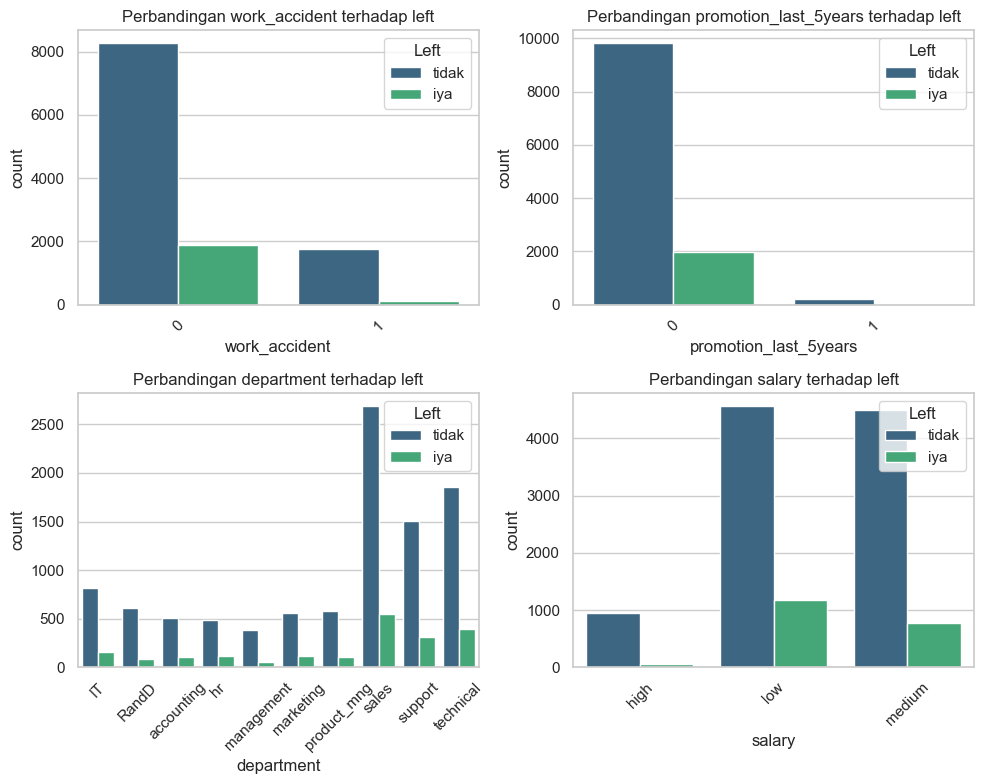

In [39]:
cat_cols_filtered = [col for col in cat_cols if col != 'left']
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Buat figure
n_cols = 2  # Tetapkan jumlah kolom tetap menjadi 2
n_rows = math.ceil(len(cat_cols_filtered) / n_cols)  # Hitung jumlah baris
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Iterasi melalui setiap kolom kategori
for i, col in enumerate(cat_cols_filtered):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(data=df_cleaned, x=col, hue='left', palette='viridis', 
                  hue_order=[0, 1])  # Pastikan urutan hue sesuai dengan data
    plt.title(f'Perbandingan {col} terhadap left')
    plt.legend(title='Left', loc='upper right', labels=['tidak', 'iya'])  # Ubah label legenda
    plt.xticks(rotation=45)  # Rotasi label x sebesar 45 derajat

plt.tight_layout()
plt.show()

Berikut adalah **analisis dan insight** dari Multivariate Analysis pada keempat grafik bar (countplot). Masing-masing menunjukkan hubungan antara variabel kategori terhadap status resign (`left`):

---

1. **Work Accident vs Left**
- **Insight:** Pegawai yang **tidak mengalami kecelakaan kerja (work_accident = 0)** memiliki jumlah resign yang **jauh lebih tinggi** dibandingkan yang mengalami kecelakaan.
- **Interpretasi:** Ini cukup menarik karena biasanya kita berpikir kecelakaan bisa membuat karyawan keluar, tapi justru yang **tidak mengalami kecelakaan lebih banyak resign**. Ini bisa jadi karena mereka kurang merasa “terikat” atau karena faktor lain seperti lingkungan kerja atau beban kerja.

---

2. **Promotion in Last 5 Years vs Left**
- **Insight:** Karyawan yang **tidak mendapat promosi dalam 5 tahun terakhir (promotion_last_5years = 0)** memiliki angka resign yang sangat tinggi.
- **Interpretasi:** Ini konsisten dengan dugaan bahwa **kurangnya penghargaan atau perkembangan karir memicu resign**. Promosi tampaknya jadi faktor penting dalam retensi karyawan.

---

3. **Department vs Left**
- **Insight:** Departemen seperti **sales, technical, dan support** memiliki jumlah resign yang lebih tinggi secara absolut.
- **Interpretasi:**
  - **Sales:** Mungkin karena tekanan target yang tinggi.
  - **Technical & Support:** Bisa jadi karena beban kerja atau kurangnya jenjang karir.
  - Departemen seperti **management dan R&D** memiliki tingkat resign yang relatif rendah, menunjukkan stabilitas yang lebih tinggi.

---

4. **Salary vs Left**
- **Insight:** Mayoritas karyawan yang resign berasal dari kelompok gaji **rendah (low)**, diikuti oleh **medium**, dan hampir tidak ada yang dari kelompok **high salary**.
- **Interpretasi:** Gaji jelas berpengaruh terhadap loyalitas. **Semakin rendah gaji, semakin tinggi potensi resign.** Ini bisa dijadikan pertimbangan dalam strategi kompensasi perusahaan.

---

**Kesimpulan Umum:**
Variabel-variabel berikut punya **korelasi kuat dengan keputusan resign**:
- Tidak mendapat promosi
- Gaji rendah
- Bekerja di departemen tertentu (sales, support, technical)
- Tidak mengalami kecelakaan kerja (mungkin korelasi tidak langsung)

#### Analisis Left terhadap Data Numerik

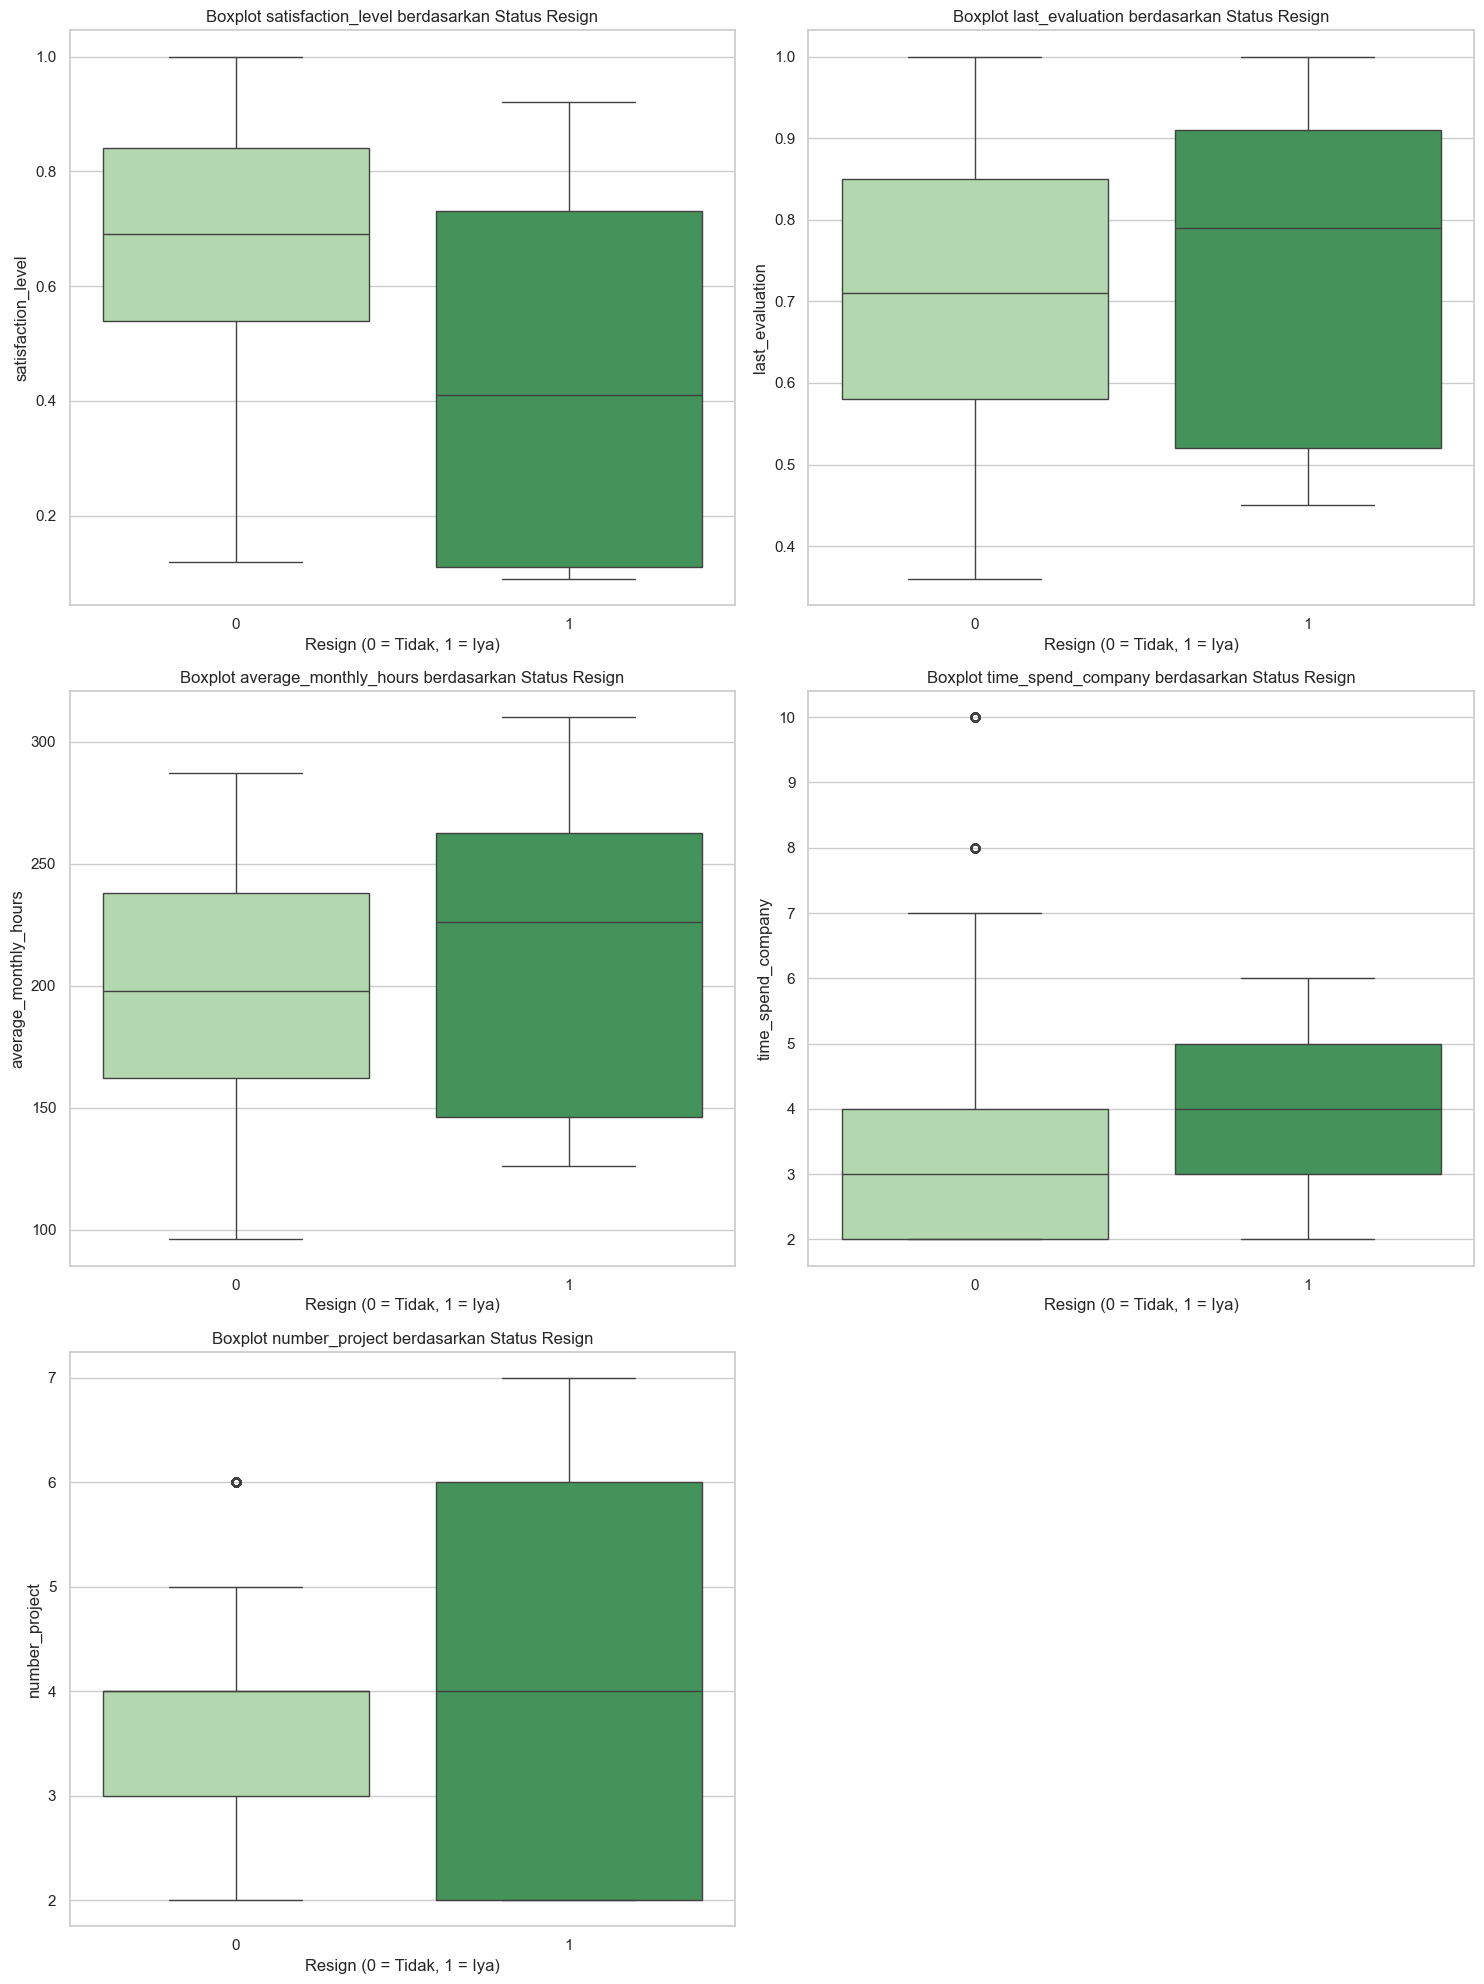

In [40]:
# List fitur numerik yang ingin dibandingkan
features = ['satisfaction_level', 'last_evaluation', 'average_monthly_hours', 'time_spend_company', 'number_project']

plt.figure(figsize=(15, 20))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='left', y=feature, data=df_cleaned, palette='Greens')
    plt.title(f'Boxplot {feature} berdasarkan Status Resign')
    plt.xlabel('Resign (0 = Tidak, 1 = Iya)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


Berikut adalah analisis dari lima **boxplot** yang membandingkan berbagai fitur numerik terhadap status **resign** (`left`: 0 = tidak resign, 1 = resign):

---

1. **Satisfaction Level**
- **Insight**: Pegawai yang resign (1) cenderung memiliki tingkat kepuasan kerja yang jauh lebih rendah dibandingkan yang tidak resign (0).
- **Interpretasi**: Kepuasan kerja rendah menjadi salah satu faktor utama seseorang memutuskan keluar dari perusahaan.

---

2. **Last Evaluation**
- **Insight**: Pegawai yang resign memiliki nilai evaluasi yang sedikit lebih tinggi secara median dibandingkan yang tidak resign.
- **Interpretasi**: Bisa jadi beberapa pegawai yang performanya tinggi merasa kurang dihargai atau tidak diberi tantangan/prospek karir, sehingga mereka memilih keluar.

---

3. **Average Monthly Hours**
- **Insight**: Pegawai yang resign bekerja lebih lama per bulan (jam kerja lebih tinggi).
- **Interpretasi**: Jam kerja yang terlalu tinggi bisa menyebabkan burnout dan meningkatkan kemungkinan resign.

---

4. **Time Spend Company**
- **Insight**: Pegawai yang resign umumnya telah bekerja lebih lama (median sekitar 4 tahun), sedangkan yang bertahan banyak di kisaran 3 tahun.
- **Interpretasi**: Masa kerja yang lama tanpa promosi atau perubahan kondisi kerja bisa menyebabkan kejenuhan, sehingga memicu resign.

---

5. **Number of Projects**
- **Insight**: Pegawai yang resign cenderung memiliki jumlah proyek yang lebih beragam (dari yang sedikit hingga sangat banyak).
- **Interpretasi**:
  - Resign bisa dipicu karena **kurangnya proyek (underutilization)** → merasa tidak berkembang.
  - Atau karena **terlalu banyak proyek (overload)** → burnout.

---

**Kesimpulan Umum**
Faktor-faktor yang paling berkorelasi dengan **resign** adalah:
- **Kepuasan kerja rendah**
- **Jam kerja yang tinggi**
- **Lama masa kerja**
- **Jumlah proyek terlalu sedikit atau terlalu banyak (kedua ekstrem)**

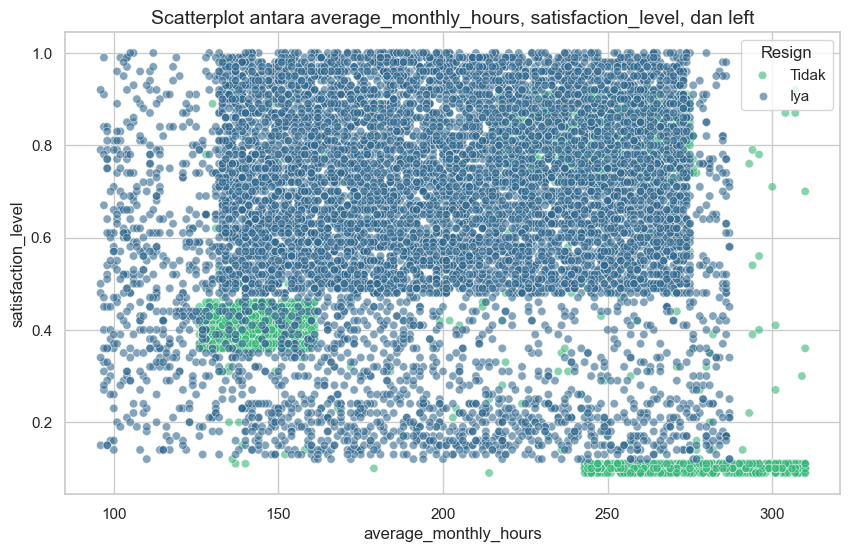

In [41]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Buat scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='average_monthly_hours', y='satisfaction_level', hue='left', palette='viridis', alpha=0.6)

# Tambahkan judul dan label
plt.title('Scatterplot antara average_monthly_hours, satisfaction_level, dan left', fontsize=14)
plt.xlabel('average_monthly_hours', fontsize=12)
plt.ylabel('satisfaction_level', fontsize=12)
plt.legend(title='Resign', labels=['Tidak', 'Iya'], loc='upper right')
plt.show()

**Scatterplot antara `average_monthly_hours`, `satisfaction_level`, dan `left` (resign)**

1. **Cluster Karyawan yang Resign**
Terdapat **dua cluster utama** karyawan yang resign (hijau):

- **Cluster 1:**  
  - **Satisfaction rendah (~0.4)**  
  - **Jam kerja bulanan normal (~130–160 jam)**  
  - ⇒ Kemungkinan mereka resign karena **tidak puas**, meski jam kerja tidak terlalu berat.
  
- **Cluster 2:**  
  - **Satisfaction sangat rendah (< 0.2)**  
  - **Jam kerja sangat tinggi (~250–310 jam)**  
  - ⇒ Menunjukkan bahwa **jam kerja berlebihan + kepuasan sangat rendah** menjadi pemicu kuat untuk resign.

2. **Mayoritas Karyawan Tidak Resign**
- Mayoritas titik biru tersebar merata dengan:
  - **Kepuasan sedang hingga tinggi (0.4–1.0)**
  - **Jam kerja antara 130–260 jam**
- Ini berarti sebagian besar karyawan yang **merasa cukup puas dan jam kerja masih dalam batas wajar** cenderung tidak resign.

3. **Jam Kerja Tinggi Tidak Selalu Berarti Resign**
- Ada titik biru (tidak resign) juga yang memiliki jam kerja tinggi, artinya **jam kerja tinggi tidak langsung menyebabkan resign**, kecuali jika diikuti dengan **kepuasan kerja rendah**.

---

📌 **Kesimpulan Insight:**
- Karyawan dengan **tingkat kepuasan rendah** cenderung lebih banyak resign, terutama jika disertai dengan:
  - Jam kerja yang **berlebihan**
  - Atau bahkan jam kerja normal tapi tetap **tidak puas**
- Ini memperkuat bahwa **faktor psikologis (kepuasan)** dan **beban kerja** adalah kombinasi penting dalam keputusan resign.

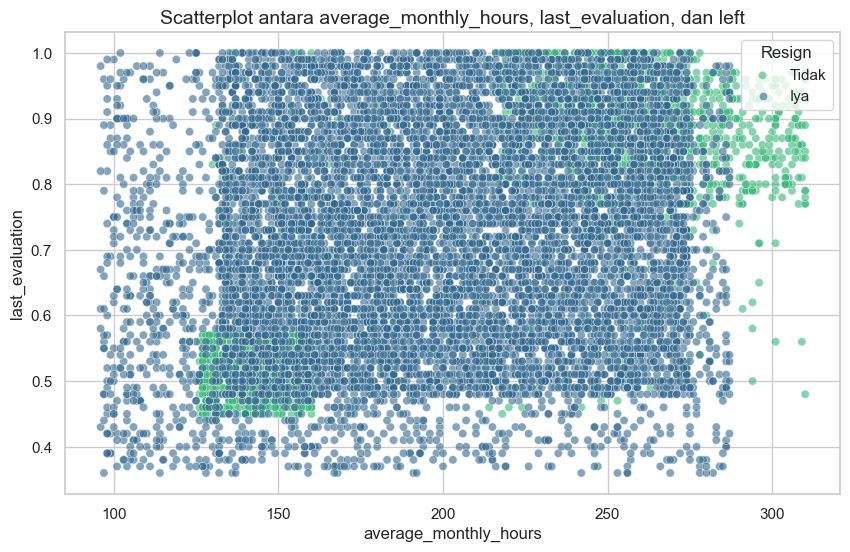

In [42]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Buat scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='average_monthly_hours', y='last_evaluation', hue='left', palette='viridis', alpha=0.6)

# Tambahkan judul dan label
plt.title('Scatterplot antara average_monthly_hours, last_evaluation, dan left', fontsize=14)
plt.xlabel('average_monthly_hours', fontsize=12)
plt.ylabel('last_evaluation', fontsize=12)
plt.legend(title='Resign', labels=['Tidak', 'Iya'], loc='upper right')
plt.show()

**Scatterplot antara `average_monthly_hours`, `last_evaluation`, dan `left` (resign)**

1. **Dua Cluster Karyawan yang Resign Terlihat Jelas**
- **Cluster A (kiri bawah-tengah)**  
  - **Evaluasi rendah (0.45–0.6)**  
  - **Jam kerja biasa (~130–160)**  
  - ⇒ Menunjukkan **karyawan dengan evaluasi rendah + jam kerja biasa** lebih cenderung resign. Bisa jadi karena merasa tidak berkembang atau tidak dihargai.

- **Cluster B (kanan atas)**  
  - **Evaluasi tinggi (>0.8)**  
  - **Jam kerja tinggi (>250 jam/bulan)**  
  - ⇒ Menunjukkan **karyawan yang performanya bagus (evaluasi tinggi)** namun **beban kerja berat**, juga cenderung resign.  
  - Ini bisa menjadi **tanda burnout**, yaitu karyawan bagus tapi kelelahan karena overload.

2. **Mayoritas Karyawan Tidak Resign Terdistribusi Merata**
- Titik biru mendominasi sebagian besar area scatterplot.  
  - Ini berarti **kombinasi rata-rata evaluasi dan jam kerja tidak selalu menyebabkan resign**, selama kondisinya masih wajar.

3. **Evaluasi Tinggi ≠ Loyalitas**
- Adanya karyawan yang mendapatkan **evaluasi tinggi tapi tetap resign** menunjukkan bahwa **kinerja tinggi bukan jaminan retensi**.
- Ini menunjukkan pentingnya memperhatikan **beban kerja** dan **kepuasan karyawan**, bukan hanya evaluasi.

---

**Kesimpulan Insight:**
- Ada dua risiko utama resign:
  1. **Evaluasi rendah + jam kerja standar** → mungkin merasa tidak berkembang
  2. **Evaluasi tinggi + jam kerja berat** → burnout
- Perusahaan perlu:
  - Memberikan **pengakuan atau dukungan** pada karyawan dengan evaluasi rendah.
  - Mencegah **overload pekerjaan** pada karyawan berkinerja tinggi.

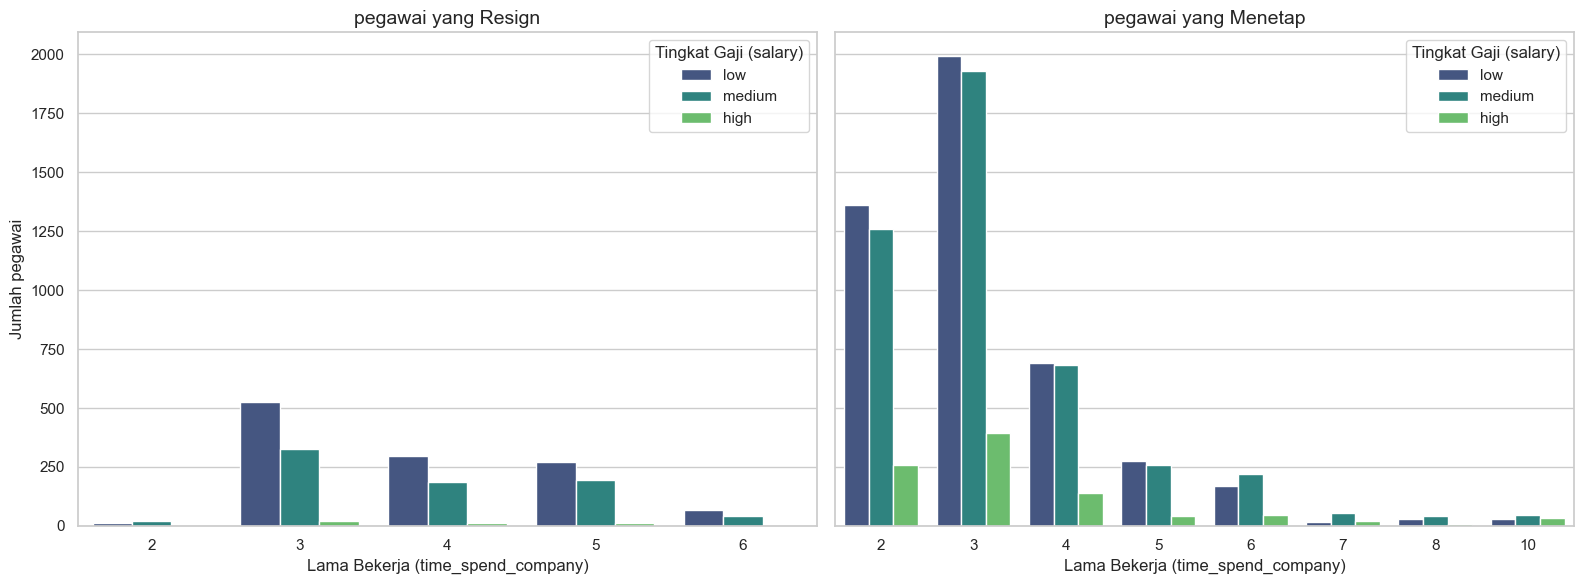

In [43]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Buat figure dengan dua subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot untuk pegawai yang resign (left = 'iya')
sns.countplot(data=df_cleaned[df_cleaned['left'] == 1], 
              x='time_spend_company', hue='salary', palette='viridis', 
              hue_order=['low', 'medium', 'high'], ax=axes[0])
axes[0].set_title('pegawai yang Resign', fontsize=14)
axes[0].set_xlabel('Lama Bekerja (time_spend_company)', fontsize=12)
axes[0].set_ylabel('Jumlah pegawai', fontsize=12)
axes[0].legend(title='Tingkat Gaji (salary)', loc='upper right')

# Plot untuk pegawai yang menetap (left = 'tidak')
sns.countplot(data=df_cleaned[df_cleaned['left'] == 0], 
              x='time_spend_company', hue='salary', palette='viridis', 
              hue_order=['low', 'medium', 'high'], ax=axes[1])
axes[1].set_title('pegawai yang Menetap', fontsize=14)
axes[1].set_xlabel('Lama Bekerja (time_spend_company)', fontsize=12)
axes[1].set_ylabel('')  # Tidak perlu label y di subplot kedua
axes[1].legend(title='Tingkat Gaji (salary)', loc='upper right')

# Tampilkan plot
plt.tight_layout()
plt.show()

**Visualisasi Perbandingan: Pegawai yang Resign vs Menetap berdasarkan Lama Bekerja dan Tingkat Gaji**

* **Sumbu X:** Lama bekerja di perusahaan (`time_spend_company`)
* **Sumbu Y:** Jumlah pegawai
* **Warna Batang:**

  * **Biru tua:** Gaji rendah (`low`)
  * **Hijau tua:** Gaji sedang (`medium`)
  * **Hijau terang:** Gaji tinggi (`high`)
* Dibagi menjadi dua panel:

  * **Kiri:** Pegawai yang *resign*
  * **Kanan:** Pegawai yang *menetap*

**Insight dari Pegawai yang Resign:**

1. **Mayoritas yang resign berada di level gaji rendah**, khususnya:

   * Tahun ke-3 paling tinggi → Pegawai yang bekerja 3 tahun dengan gaji rendah paling banyak resign.
   * Disusul tahun ke-4 dan ke-5, juga didominasi gaji rendah.
   * Hampir tidak ada pegawai bergaji tinggi yang resign.

2. **Resign paling jarang terjadi di tahun ke-2 atau ke-6**, apalagi dengan gaji tinggi.

---

**Insight dari Pegawai yang Menetap:**

1. **Tingkat retensi paling tinggi terjadi pada pegawai yang telah bekerja selama 3 tahun**, terutama dengan:

   * Gaji rendah dan sedang.
   * Menunjukkan bahwa setelah 3 tahun, sebagian besar pegawai tetap bertahan.

2. **Pegawai dengan gaji tinggi memiliki kecenderungan lebih besar untuk bertahan**, meskipun jumlahnya tidak sebanyak pegawai dengan gaji rendah/menengah.

3. **Mereka yang sudah bekerja 6 tahun ke atas (hingga 10 tahun)** cenderung tetap tinggal di perusahaan, walaupun jumlahnya kecil.

---

🧠 **Kesimpulan Strategis:**

📌 Untuk Mencegah Resign:

* Fokus pada pegawai **gaji rendah dan sedang** yang telah bekerja **3–5 tahun**, karena mereka paling rentan resign.
* Pertimbangkan peningkatan gaji atau insentif setelah masa kerja 2–3 tahun sebagai bentuk retensi.
* Pegawai **bergaji tinggi jarang resign**, jadi mempertahankan dan memotivasi mereka penting untuk jangka panjang.

📌 Untuk Perusahaan:

* Buat program loyalitas atau kenaikan jenjang karier yang dimulai sejak tahun ke-2 atau ke-3.
* Evaluasi apakah gaji rendah di tahun-tahun krusial (3–5 tahun) memicu rasa tidak dihargai hingga pegawai memilih keluar.



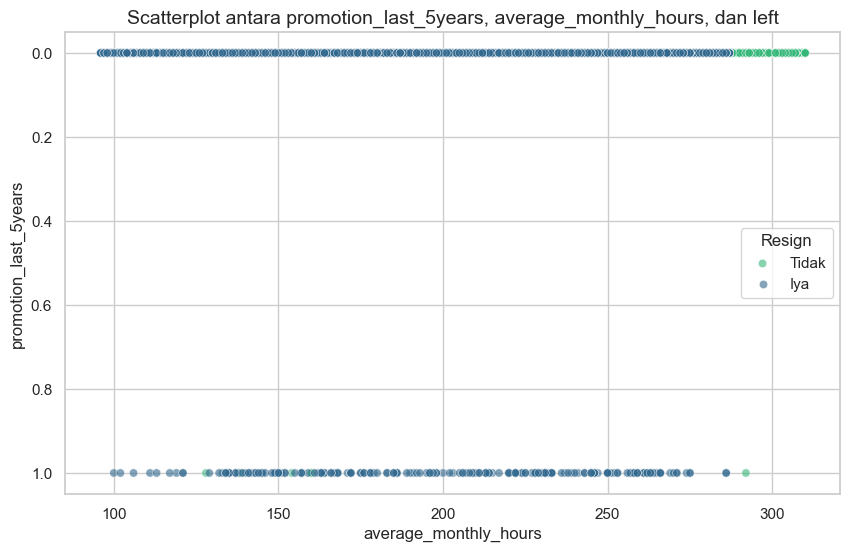

In [44]:
# Atur tema warna hijau
sns.set_theme(style="whitegrid")

# Buat scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, y='promotion_last_5years', x='average_monthly_hours', hue='left', palette='viridis', alpha=0.6)

# Tambahkan judul dan label
plt.title('Scatterplot antara promotion_last_5years, average_monthly_hours, dan left', fontsize=14)
plt.ylabel('promotion_last_5years', fontsize=12)
plt.xlabel('average_monthly_hours', fontsize=12)
plt.legend(title='Resign', labels=['Tidak', 'Iya'])
plt.show()

**Scatterplot: Hubungan antara `promotion_last_5years`, `average_monthly_hours`, dan `left` (resign)**

* **Sumbu X:** Rata-rata jam kerja bulanan (`average_monthly_hours`)
* **Sumbu Y:** Status promosi dalam 5 tahun terakhir (`promotion_last_5years`):

  * **0** = Tidak pernah dipromosikan
  * **1** = Pernah dipromosikan
* **Warna Titik:**

  * Hijau muda = Tidak resign
  * Biru = Resign

**Insight Utama:**

1. **Mayoritas Pegawai Tidak Pernah Mendapat Promosi**

* Hampir semua titik berada pada **sumbu Y = 0**, menunjukkan bahwa sebagian besar pegawai **tidak mendapatkan promosi dalam 5 tahun terakhir**, baik yang resign maupun yang tidak.

2. **Pegawai yang Pernah Dipromosikan Jarang Resign**

* Di sumbu Y = 1 (mendapat promosi), sebagian besar titik berwarna **biru muda** (tidak resign), hanya sedikit yang berwarna biru tua (resign).
* Ini menunjukkan bahwa **promosi memiliki hubungan positif dengan retensi pegawai**.

3. **Resign Tetap Terjadi Walau Jam Kerja Tinggi**

* Banyak titik biru (resign) yang berada di **average\_monthly\_hours tinggi (di atas 250 jam)** dan **tidak pernah dipromosikan** → Ini mengindikasikan bahwa:

  > Pegawai yang bekerja sangat keras tetapi **tidak pernah mendapatkan promosi** cenderung lebih besar kemungkinan untuk resign.

---

🧠 **Kesimpulan Strategis:**

📌 Untuk Mencegah Resign:

* **Berikan promosi atau penghargaan** pada pegawai yang memiliki **jam kerja tinggi**, agar mereka merasa diakui dan dihargai.
* Evaluasi dan **tingkatkan sistem promosi internal** karena terbukti berkontribusi terhadap **retensi pegawai**.

📌 Untuk Pengembangan HR:

* Lakukan audit terhadap pegawai dengan jam kerja tinggi dan masa kerja panjang yang belum mendapat promosi → Ini adalah kelompok risiko tinggi untuk resign.
* Transparansi dalam jalur karier dan evaluasi promosi perlu diperbaiki.



In [45]:
df_cleaned.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [46]:
# Data Encoding

# Salin dataframe
df_encoded = df_cleaned.copy()

# Ordinal encoding untuk salary
salary_order = ['low', 'medium', 'high']
ordinal_enc = OrdinalEncoder(categories=[salary_order])
df_encoded['salary'] = ordinal_enc.fit_transform(df_cleaned[['salary']])

# One-hot encoding untuk department
df_encoded = pd.get_dummies(df_encoded, columns=['department'], drop_first=True)

# Optional: ubah kategori lain ke integer (jika belum)
for col in ['work_accident', 'promotion_last_5years', 'left']:
    df_encoded[col] = df_encoded[col].astype(int)

df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0.0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1.0,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1.0,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0.0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0.0,False,False,False,False,False,False,True,False,False


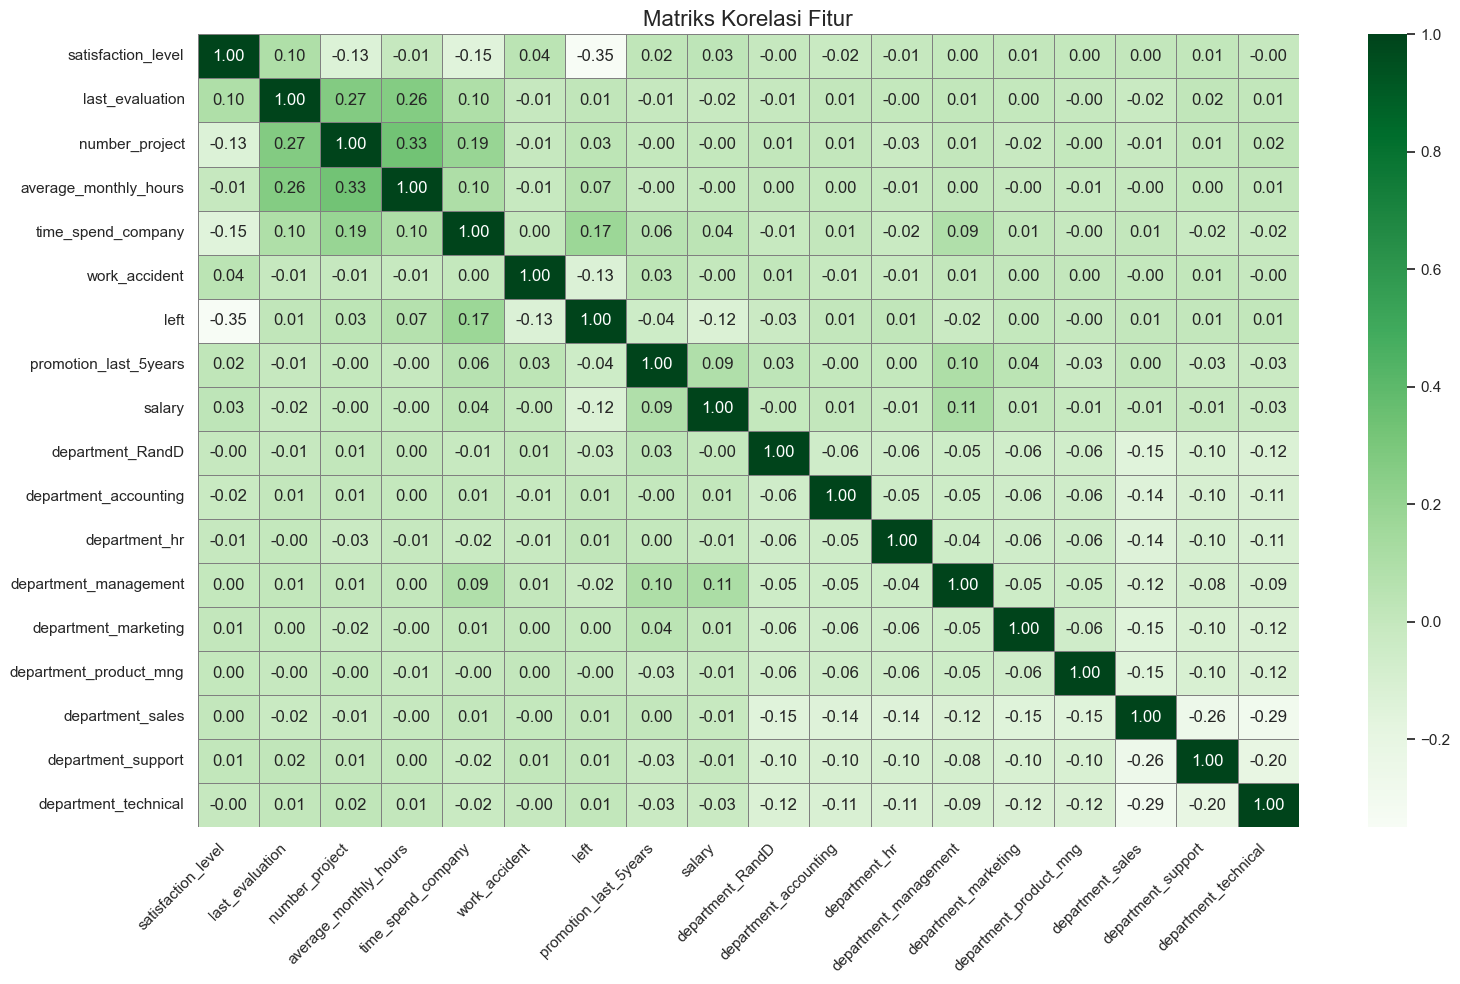

In [47]:
# Hitung korelasi
correlation_matrix = df_encoded.corr(numeric_only=True)

# Set tema warna hijau
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="Greens", 
            linewidths=0.5, 
            linecolor='gray')

plt.title("Matriks Korelasi Fitur", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**🔍 Insight Matriks Korelasi Terhadap `left`**

Berikut beberapa insight penting:

| Fitur                     | Korelasi terhadap `left` | Keterangan                                                                 |
|--------------------------|--------------------------|----------------------------------------------------------------------------|
| `satisfaction_level`     | **-0.35**                | Korelasi negatif kuat → makin puas, makin kecil kemungkinan resign         |
| `time_spend_company`     | 0.17                     | Korelasi positif ringan → makin lama di perusahaan, sedikit lebih rentan resign |
| `number_project`         | 0.03                     | Korelasi sangat kecil                                                      |
| `average_monthly_hours`  | 0.07                     | Korelasi sangat kecil                                                      |
| `last_evaluation`        | 0.01                     | Hampir tidak berkorelasi                                                   |
| `promotion_last_5years` | **-0.13**                | Korelasi negatif → yang pernah dipromosi, cenderung tidak resign           |
| `work_accident`          | **-0.13**                | Korelasi negatif → yang pernah kecelakaan kerja, cenderung bertahan        |
| `salary`                 | -0.12                    | Korelasi negatif → makin tinggi gaji, makin kecil kemungkinan resign        |

---

**🟩 Interpretasi Singkat:**

- **Fitur paling penting** berdasarkan korelasi:  
  ✅ `satisfaction_level`  
  ✅ `promotion_last_5years`  
  ✅ `work_accident`  
  ✅ `salary`

- Fitur **department** hampir semuanya memiliki korelasi kecil terhadap `left` (mungkin bisa dipertimbangkan apakah relevan atau tidak nanti pas modeling). Namun, saya akan mencoba menggunakan semua fitur yang ada pada plot matriks korelasi untuk digunakan pada pelatihan model. Bila hasilnya di bawah 80%, maka saya akan mencoba melakukan tuning. Bila hasilnya masih di bawah 90%, saya akan mencoba melakukan reduksi dimensi.


### 📌 Ringkasan Insight dari **Exploratory Data Analysis**

1. **Data Cleaning**
- **Standardisasi Nama Kolom**: Nama kolom diubah menjadi huruf kecil dan typo diperbaiki (contoh: `average_montly_hours` → `average_monthly_hours`).
- **Missing Values**: Tidak ada nilai yang hilang dalam dataset.
- **Data Duplikat**: Ditemukan 3008 baris duplikat (20,05%) yang dihapus, menyisakan 11.991 baris data.
- **Outliers**: Terdapat outliers pada `time_spend_company`, tetapi tidak ekstrem sehingga dibiarkan untuk menjaga pola data.

---

2. **Univariate Analysis**
- **Categorical Features**:
  - **`left`**: 16.6% karyawan resign, mayoritas (83.4%) tetap bekerja.
  - **`work_accident`**: 84.6% tidak pernah mengalami kecelakaan kerja.
  - **`promotion_last_5years`**: Hanya 1.7% karyawan yang pernah dipromosikan.
  - **`department`**: Divisi terbesar adalah **sales**, diikuti **technical** dan **support**. Divisi **management** memiliki jumlah karyawan paling sedikit.
  - **`salary`**: Mayoritas karyawan memiliki gaji rendah (47.9%) atau menengah (43.9%), hanya 8.3% bergaji tinggi.

- **Numerical Features**:
  - **`satisfaction_level`**: Distribusi bimodal, dengan kelompok puas tinggi (~0.7–0.8) dan rendah (~0.4–0.5).
  - **`last_evaluation`**: Distribusi merata, dengan puncak kecil di ~0.55–0.6.
  - **`number_projects`**: Mayoritas menangani 3–5 proyek.
  - **`average_monthly_hours`**: Distribusi bimodal (~150 jam dan ~250 jam).
  - **`time_spend_company`**: Mayoritas bekerja 2–3 tahun, dengan lonjakan kecil di tahun ke-4 dan ke-5.

---

3. **Multivariate Analysis**
- **Categorical Features vs `left`**:
  - **`work_accident`**: Karyawan yang tidak mengalami kecelakaan lebih banyak resign.
  - **`promotion_last_5years`**: Karyawan yang tidak dipromosikan lebih banyak resign.
  - **`department`**: Divisi **sales**, **technical**, dan **support** memiliki jumlah resign tertinggi.
  - **`salary`**: Resign lebih banyak terjadi pada karyawan bergaji rendah.

- **Numerical Features vs `left`**:
  - **`satisfaction_level`**: Karyawan yang resign memiliki tingkat kepuasan lebih rendah.
  - **`last_evaluation`**: Karyawan yang resign memiliki evaluasi sedikit lebih tinggi.
  - **`average_monthly_hours`**: Karyawan yang resign bekerja lebih lama per bulan.
  - **`time_spend_company`**: Resign lebih banyak terjadi pada karyawan dengan masa kerja 3–5 tahun.
  - **`number_projects`**: Resign terjadi pada karyawan dengan proyek terlalu sedikit atau terlalu banyak.

- **Scatterplot Insight**:
  - **`satisfaction_level` vs `average_monthly_hours`**: Resign terjadi pada karyawan dengan kepuasan rendah, baik dengan jam kerja normal (~130–160 jam) maupun tinggi (~250–310 jam).
  - **`last_evaluation` vs `average_monthly_hours`**: Resign terjadi pada karyawan dengan evaluasi rendah (~0.45–0.6) dan jam kerja normal, atau evaluasi tinggi (>0.8) dan jam kerja tinggi (>250 jam).
  - **`time_spend_company` vs `salary`**: Resign paling banyak terjadi pada karyawan bergaji rendah dengan masa kerja 3–5 tahun.

---

4. **Correlation Analysis**
- **Fitur dengan Korelasi Tinggi terhadap `left`**:
  - **Negatif**: `satisfaction_level` (-0.35), `promotion_last_5years` (-0.13), `work_accident` (-0.13), `salary` (-0.12).
  - **Positif**: `time_spend_company` (0.17).
- **Fitur seperti `number_project` dan `last_evaluation` memiliki korelasi sangat kecil.**

---

**Kesimpulan Strategis**
1. **Faktor Utama Resign**:
   - Kepuasan kerja rendah.
   - Tidak mendapat promosi.
   - Gaji rendah.
   - Jam kerja tinggi (burnout).
   - Lama bekerja (3–5 tahun).

**Rekomendasi**:
   - Tingkatkan kepuasan kerja melalui insentif, promosi, dan pengakuan.
   - Fokus pada retensi karyawan bergaji rendah dengan masa kerja 3–5 tahun.
   - Hindari overload pekerjaan pada karyawan berkinerja tinggi.

## Train-Test Split

In [48]:
# 1. Pisahkan fitur (X) dan target (y)
X = df_encoded.drop(columns='left')
y = df_encoded['left']

# 2. Lakukan pembagian data (misalnya 80% untuk train dan 20% untuk test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [49]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
2041,0.98,0.91,4,240,3,0,0,0.0,False,False,False,False,False,False,False,False,True
10444,0.63,0.89,3,239,3,0,0,1.0,False,False,False,False,False,False,False,False,False
2030,0.85,0.59,3,235,3,0,0,0.0,False,False,False,False,False,False,False,True,False
11606,0.56,0.39,3,106,8,0,0,2.0,False,False,False,True,False,False,False,False,False
2008,0.50,0.75,6,127,3,0,0,0.0,False,False,False,False,False,False,True,False,False


In [50]:
y_train.value_counts()

left
0    7999
1    1593
Name: count, dtype: int64

In [51]:
portion_train = X_train.shape[0] / X.shape[0]
portion_test = X_test.shape[0] / X.shape[0]

print(f'shape of X_train: {X_train.shape}')
print(f'shape of y_train: {y_train.shape}')
print(f'shape of X_test: {X_test.shape}')
print(f'shape of y_test: {y_test.shape}')
print(f'percentage of train size: {portion_train:.2f}%')
print(f'percentage of test size: {portion_test:.2f}%')

shape of X_train: (9592, 17)
shape of y_train: (9592,)
shape of X_test: (2399, 17)
shape of y_test: (2399,)
percentage of train size: 0.80%
percentage of test size: 0.20%


## Model Development

### Base Model Development

In [52]:
nb = GaussianNB()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

nb.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

classification_models = [nb, rf, xgb]
classification_models


[GaussianNB(),
 RandomForestClassifier(random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...)]

### Base Model Evaluation

In [53]:
# Definisi fungsi evaluasi model
def models_evaluation(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    mse = mean_squared_error(y, y_pred)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    return accuracy, f1, mse, cm

# Inisialisasi list untuk menyimpan hasil evaluasi
model_names = []
accuracies_train = []
f1_scores_train = []
mses_train = []
cms_train = []

accuracies_test = []
f1_scores_test = []
mses_test = []
cms_test = []

# Evaluasi untuk setiap model
for model in classification_models:
    # Evaluasi pada data train
    accuracy_train, f1_train, mse_train, cm_train = models_evaluation(model, X_train, y_train)
    accuracies_train.append(accuracy_train)
    f1_scores_train.append(f1_train)
    mses_train.append(mse_train)
    cms_train.append(cm_train)
    
    # Evaluasi pada data test
    accuracy_test, f1_test, mse_test, cm_test = models_evaluation(model, X_test, y_test)
    accuracies_test.append(accuracy_test)
    f1_scores_test.append(f1_test)
    mses_test.append(mse_test)
    cms_test.append(cm_test)
    
    # Nama model
    model_names.append(model.__class__.__name__)

# Menampilkan hasil evaluasi dalam tabel
evaluations = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': accuracies_train,
    'Train F1 Score': f1_scores_train,
    'Train MSE': mses_train,
    'Test Accuracy': accuracies_test,
    'Test F1 Score': f1_scores_test,
    'Test MSE': mses_test
})

display(evaluations)  # Pastikan tabel muncul di Jupyter Notebook

,Model,Train Accuracy,Train F1 Score,Train MSE,Test Accuracy,Test F1 Score,Test MSE
0,GaussianNB,0.822456,0.834624,0.177544,0.842018,0.851515,0.157982
1,RandomForestClassifier,1.000000,1.000000,0.000000,0.985827,0.985634,0.014173
2,XGBClassifier,0.996038,0.996026,0.003962,0.982493,0.982385,0.017507


In [54]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Buat objek StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Buat dictionary model
models_cv = {
    "GaussianNB": nb,
    "RandomForest": rf,
    "XGBoost": xgb
}

# Evaluasi cross-validation (scoring pakai 'accuracy' atau 'f1_weighted')
for name, model in models_cv.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')  # bisa diganti jadi 'f1_weighted'
    print(f"{name} - Mean Accuracy: {scores.mean():.4f}, Std Dev: {scores.std():.4f}")


GaussianNB - Mean Accuracy: 0.8145, Std Dev: 0.0137
RandomForest - Mean Accuracy: 0.9837, Std Dev: 0.0018
XGBoost - Mean Accuracy: 0.9819, Std Dev: 0.0025


Dapat dilihat RandomForestClassifier memiliki nilai akurasi yang lebih tinggi. Namun masih ada terdapat indikasi overfitting, walau memang selisih nilai akurasi pada training set dan test set tidaklah banyak. Jadi saya akan memilih model RandomForestClassifier untuk dilakukan Hyperparameter Tuning dengan harapan agar gap atau selisih antara nilai akurasi training dan akurasi tes berkurang..

### Model Hyperparameter Tuning

In [55]:
# Definisi ruang pencarian hyperparameter untuk setiap model
search_spaces = {
    'RandomForestClassifier': {
        'n_estimators': (10, 200),
        'max_depth': (1, 50),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 20)
    }
}

# Inisialisasi hasil tuning
tuned_models = {}

# Cross-validation dengan StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lakukan tuning untuk setiap model
for model in classification_models:
    model_name = model.__class__.__name__
    if model_name in search_spaces:
        print(f"Tuning hyperparameter untuk {model_name}...")
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=search_spaces[model_name],
            n_iter=30,  # Jumlah iterasi pencarian
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        bayes_search.fit(X_train, y_train)
        tuned_models[model_name] = bayes_search.best_estimator_
        print(f"Best parameters for {model_name}: {bayes_search.best_params_}")
        print(f"Best score for {model_name}: {bayes_search.best_score_:.4f}\n")

Tuning hyperparameter untuk RandomForestClassifier...
Best parameters for RandomForestClassifier: OrderedDict([('max_depth', 21), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 100)])
Best score for RandomForestClassifier: 0.9839



,Model,Train Accuracy,Train F1 Score,Train MSE,Test Accuracy,Test F1 Score,Test MSE
0,RandomForestClassifier (Sebelum Tuning),1.000000,1.000000,0.000000,0.985827,0.985634,0.014173
1,RandomForestClassifier (Setelah Tuning),0.997081,0.997075,0.002919,0.986244,0.986049,0.013756


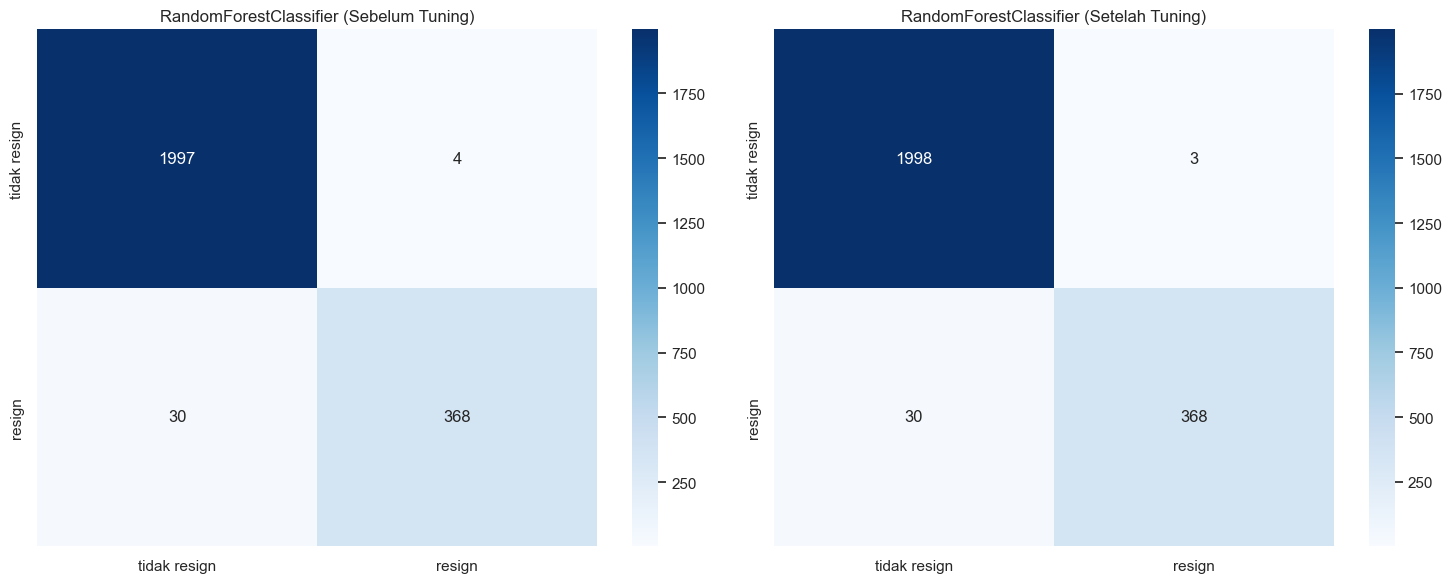

In [56]:
# Evaluasi ulang model klasifikasi setelah tuning
tuned_model_names = []
tuned_accuracies_train = []
tuned_f1_scores_train = []
tuned_mses_train = []
tuned_accuracies_test = []
tuned_f1_scores_test = []
tuned_mses_test = []
tuned_cms = []

rf_before = rf
train_accuracy_before = rf_before.score(X_train, y_train)
test_accuracy_before = rf_before.score(X_test, y_test)

for model_name, tuned_model in tuned_models.items():
    # Ubah nama model RandomForestClassifier setelah tuning
    if model_name == "RandomForestClassifier":
        model_name = "RandomForestClassifier (Setelah Tuning)"
    
    # Evaluasi pada training set
    accuracy_train, f1_train, mse_train, _ = models_evaluation(tuned_model, X_train, y_train)
    tuned_accuracies_train.append(accuracy_train)
    tuned_f1_scores_train.append(f1_train)
    tuned_mses_train.append(mse_train)
    
    # Evaluasi pada test set
    accuracy_test, f1_test, mse_test, cm_test = models_evaluation(tuned_model, X_test, y_test)
    tuned_accuracies_test.append(accuracy_test)
    tuned_f1_scores_test.append(f1_test)
    tuned_mses_test.append(mse_test)
    tuned_cms.append(cm_test)
    
    # Nama model
    tuned_model_names.append(model_name)

# Menampilkan hasil evaluasi setelah tuning dalam tabel
tuned_evaluations = pd.DataFrame({
    'Model': tuned_model_names,
    'Train Accuracy': tuned_accuracies_train,
    'Train F1 Score': tuned_f1_scores_train,
    'Train MSE': tuned_mses_train,
    'Test Accuracy': tuned_accuracies_test,
    'Test F1 Score': tuned_f1_scores_test,
    'Test MSE': tuned_mses_test
})

# Tambahkan evaluasi model sebelum tuning ke dalam tabel
rf_before_tuning = {
    'Model': 'RandomForestClassifier (Sebelum Tuning)',  # Nama model sebelum tuning
    'Train Accuracy': accuracies_train[1],  # Akurasi training sebelum tuning
    'Train F1 Score': f1_scores_train[1],   # F1 Score training sebelum tuning
    'Train MSE': mses_train[1],             # MSE training sebelum tuning
    'Test Accuracy': accuracies_test[1],    # Akurasi testing sebelum tuning
    'Test F1 Score': f1_scores_test[1],     # F1 Score testing sebelum tuning
    'Test MSE': mses_test[1]                # MSE testing sebelum tuning
}

# Tambahkan ke tabel evaluasi setelah tuning
tuned_evaluations = pd.concat([
    pd.DataFrame([rf_before_tuning]),  # Data sebelum tuning
    tuned_evaluations                  # Data setelah tuning
], ignore_index=True)

# Tampilkan tabel evaluasi yang diperbarui
display(tuned_evaluations)

y_pred_before = rf_before.predict(X_test)
cm_before = confusion_matrix(y_test, y_pred_before)

# Menentukan ukuran grid subplot untuk confusion matrix sebelum dan sesudah tuning
fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2)

# Confusion matrix sebelum tuning
sns.heatmap(cm_before, annot=True, fmt='d', ax=axes[0], cmap="Blues", 
            xticklabels=["tidak resign", "resign"], 
            yticklabels=["tidak resign", "resign"])
axes[0].set_title("RandomForestClassifier (Sebelum Tuning)", fontsize=12)

# Confusion matrix sesudah tuning
sns.heatmap(tuned_cms[0], annot=True, fmt='d', ax=axes[1], cmap="Blues", 
            xticklabels=["tidak resign", "resign"], 
            yticklabels=["tidak resign", "resign"])
axes[1].set_title("RandomForestClassifier (Setelah Tuning)", fontsize=12)

plt.tight_layout()
plt.show()


In [57]:
# Prediksi pada data test
y_pred_tuned = tuned_models['RandomForestClassifier'].predict(X_test)

# Buat classification report
report = classification_report(y_test, y_pred_tuned, target_names=['Tidak Resign', 'Resign'])
print(report)

              precision    recall  f1-score   support

Tidak Resign       0.99      1.00      0.99      2001
      Resign       0.99      0.92      0.96       398

    accuracy                           0.99      2399
   macro avg       0.99      0.96      0.97      2399
weighted avg       0.99      0.99      0.99      2399



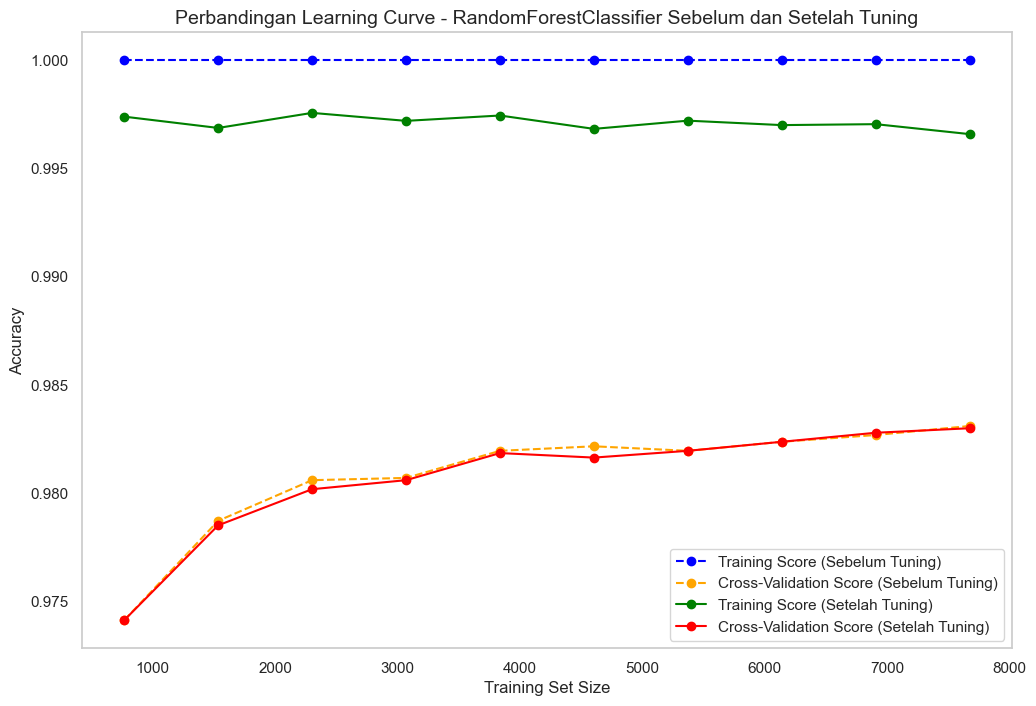

In [58]:
# Identifikasi underfitting atau overfitting dengan Learning Curve untuk model sebelum tuning
train_sizes_before, train_scores_before, test_scores_before = learning_curve(
    rf_before, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean_before = np.mean(train_scores_before, axis=1)
test_mean_before = np.mean(test_scores_before, axis=1)

# Identifikasi underfitting atau overfitting dengan Learning Curve untuk model setelah tuning
train_sizes_after, train_scores_after, test_scores_after = learning_curve(
    tuned_models['RandomForestClassifier'], X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean_after = np.mean(train_scores_after, axis=1)
test_mean_after = np.mean(test_scores_after, axis=1)

# Plot perbandingan Learning Curve
plt.figure(figsize=(12, 8))

# Plot untuk model sebelum tuning
plt.plot(train_sizes_before, train_mean_before, label="Training Score (Sebelum Tuning)", marker='o', linestyle='--', color='blue')
plt.plot(train_sizes_before, test_mean_before, label="Cross-Validation Score (Sebelum Tuning)", marker='o', linestyle='--', color='orange')

# Plot untuk model setelah tuning
plt.plot(train_sizes_after, train_mean_after, label="Training Score (Setelah Tuning)", marker='o', linestyle='-', color='green')
plt.plot(train_sizes_after, test_mean_after, label="Cross-Validation Score (Setelah Tuning)", marker='o', linestyle='-', color='red')

# Tambahkan judul dan label
plt.title("Perbandingan Learning Curve - RandomForestClassifier Sebelum dan Setelah Tuning", fontsize=14)
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid()
plt.show()

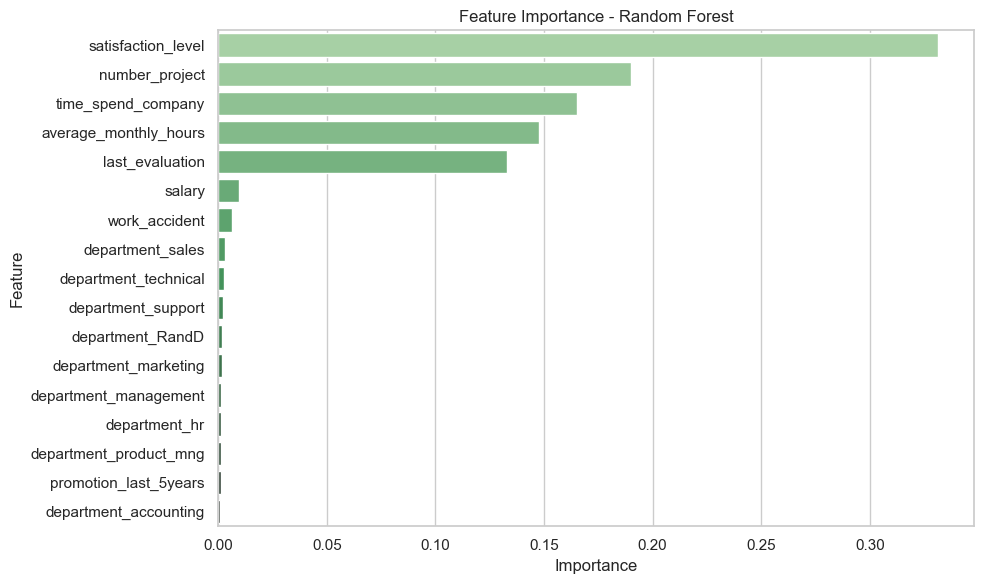

In [59]:
# IMPORT LIBRARY
importances_rf = tuned_models['RandomForestClassifier'].feature_importances_
importances_xgb = xgb.feature_importances_

# Buat DataFrame untuk mempermudah visualisasi
features = X_train.columns

# DataFrame untuk Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': features,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)


# Plot Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_rf, x='Importance', y='Feature', palette='Greens_d')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()